# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2385]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

In [2386]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2387]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [2388]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [2389]:
azdias.shape

(891221, 85)

In [2390]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [2391]:
feat_info.shape

(85, 4)

In [2392]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.8+ KB


In [2393]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


 ## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [2394]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [2395]:
azdias.isna().sum().sum()

4896838

There are 4896838 items in the dataset that Pandas automatically identified as being missing.

In [2396]:
azdias.isna().mean().sort_values(ascending=False)

KK_KUNDENTYP    0.655967
KBA05_ANTG1     0.149597
KBA05_ANTG2     0.149597
KBA05_ANTG3     0.149597
KBA05_ANTG4     0.149597
                  ...   
SEMIO_MAT       0.000000
SEMIO_REL       0.000000
SEMIO_FAM       0.000000
SEMIO_SOZ       0.000000
AGER_TYP        0.000000
Length: 85, dtype: float64

In [2397]:
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,XX]      1
[-1,0,9]     1
[XX]         1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [2398]:
# These will probably be taking care of by pandas missing values detection
feat_info[feat_info['missing_or_unknown']=='[]']

,attribute,information_level,type,missing_or_unknown
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
51,ANZ_HH_TITEL,building,numeric,[]
53,KONSUMNAEHE,building,ordinal,[]
69,GEBAEUDETYP_RASTER,region_rr1,ordinal,[]
71,MOBI_REGIO,region_rr1,ordinal,[]
72,ONLINE_AFFINITAET,region_rr1,ordinal,[]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


In [2399]:
azdias['ANZ_HH_TITEL'].isna().sum()

97008

In [2400]:
azdias['MOBI_REGIO'].isna().sum()

133324

In [2401]:
azdias['GFK_URLAUBERTYP'].isna().sum()

4854

In [2402]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [2403]:
# see how much data takes on a 'missing' or 'unknown' code
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

#### Find features where missing or unknown codes contains -1 or 0

feat_info shows that any of the values with -1 or 0 are classified as unknown values or no classification possible. I will search feat_info to find the features with missing or unknown codes containing -1 or 0

In [2404]:
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,XX]      1
[-1,0,9]     1
[XX]         1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [2405]:
# store subset of columns to update in replace_minus1_cols
replace_minus1_cols = feat_info[feat_info['missing_or_unknown'].str.contains('-1')]['attribute'].tolist()

In [2406]:
# store subset of columns to update in replace_zero_cols
replace_zero_cols = feat_info[feat_info['missing_or_unknown'].str.contains('0')]['attribute'].tolist()

In [2407]:
azdias[replace_minus1_cols].columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'KKK', 'REGIOTYP',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
       'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 

In [2408]:
azdias[replace_zero_cols].columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'GEBURTSJAHR', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'TITEL_KZ', 'ALTER_HH',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'REGIOTYP', 'PLZ8_BAUMAX',
       'ORTSGR_KLS9'],
      dtype='object')

#### Find features where missing or unknown codes contains XX or X

The next step is to gather the features where missing or unknown codes contains XX or X.  We  will then replace the XX and X with np.nan for only those specific features (columns)

In [2409]:
# store subset of columns to update in replace_x_cols
replace_x_cols = feat_info[(feat_info['missing_or_unknown'].str.contains('X')) | 
                          (feat_info['missing_or_unknown'].str.contains('XX'))]['attribute'].tolist()

replace_x_cols 

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [2410]:
azdias[replace_x_cols].columns

Index(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')

#### Find features where missing or unknown codes contains 9

Next, we gather the features where the missing or unknown codes contains 9.  We will then replace the 9 with np.nan for only those specific columns.

In [2411]:
# store subset of columns to update in replace_9_cols
replace_9_cols = feat_info[feat_info['missing_or_unknown'].str.contains('9')]['attribute'].tolist()

['ALTERSKATEGORIE_GROB',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP',
 'ARBEIT',
 'RELAT_AB']

In [2412]:
# Do a quick check that the columns pulled are correct
azdias[replace_9_cols].columns

Index(['ALTERSKATEGORIE_GROB', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP', 'ARBEIT', 'RELAT_AB'],
      dtype='object')

In [2413]:
azdias[replace_9_cols].head()

,ALTERSKATEGORIE_GROB,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ZABEOTYP,ARBEIT,RELAT_AB
0,2,2,6,7,5,1,5,3,3,4,7,6,6,5,3,3,NaN,NaN
1,1,5,4,4,3,1,2,2,3,6,4,7,4,7,6,5,3.0,4.0
2,3,4,1,3,3,4,4,6,3,4,7,7,7,3,3,5,3.0,2.0
3,4,5,1,2,1,4,4,7,4,3,4,4,5,4,4,3,2.0,3.0
4,3,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4,4.0,5.0


In [2414]:
azdias.isna().sum().sum()

4896838

#### Replace unknown values as indicated in data dictionary in azdias dataset ( -1,  0, 9, X, XX) with np.nan

In [2415]:
# Make a copy and call it azdias_updated
azdias_updated = azdias.copy()

In [2416]:
start_time=time.time()
# Replace all -1 in azdias[replace_minus1_cols] with np.nan
azdias_updated[replace_minus1_cols] = azdias_updated[replace_minus1_cols].replace(-1, np.nan)

# Replace all 0 in azdias[replace_zero_cols] with np.nan
azdias_updated[replace_zero_cols] = azdias_updated[replace_zero_cols].replace(0, np.nan)

# Replace 9 in azdias[replace_9_cols] with np.nan
azdias_updated[replace_x_cols] = azdias_updated[replace_x_cols].replace(['X','XX'], np.nan)

# Replace 9 in azdias[replace_9_cols] with np.nan
azdias_updated[replace_9_cols] = azdias_updated[replace_9_cols].replace(9, np.nan)

print('runtime:',round((time.time() - start_time),3),'seconds')

runtime: 4.497 seconds


In [2417]:
azdias_updated.isna().sum().sum()

8373929

In [2418]:
azdias.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [2419]:
azdias_updated.isna().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [2420]:
azdias.isna().sum().sum()

4896838

In [2421]:
azdias_updated.isna().sum().sum()

8373929

In [2422]:
azdias_updated.isna().mean().mean()

0.11054139407027654

Now we have 8,373,929 missing data items, up from 4,896,838 from the dataset before converting additional values to NaN.  The total number of missing values accounts for roughly 11% of all entries in the dataset.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

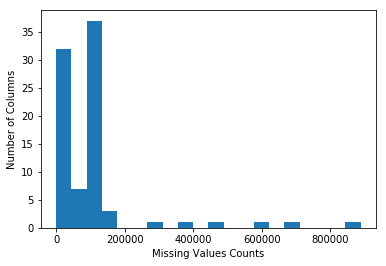

In [2423]:
# Perform an assessment of how much missing data there is in each column of the dataset.
na_count = azdias_updated.isna().sum()
plt.hist(na_count, bins=20)
plt.ylabel('Number of Columns')
plt.xlabel('Missing Values Counts')
plt.show();

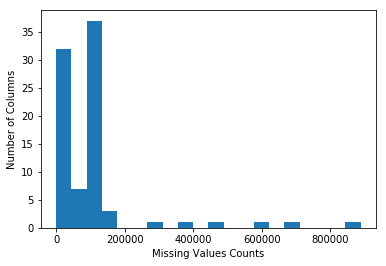

In [2424]:
# Perform an assessment of how much missing data there is in each column of the dataset.
na_count = azdias_updated.isna().sum()
plt.hist(na_count, bins=20)
plt.ylabel('Number of Columns')
plt.xlabel('Missing Values Counts')
plt.show();

In [2425]:
azdias_updated.isna().mean().sort_values(ascending=False).head(25)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
KBA05_GBZ         0.149597
MOBI_REGIO        0.149597
KBA05_ANTG1       0.149597
KBA05_ANTG2       0.149597
KBA05_ANTG3       0.149597
PLZ8_GBZ          0.130736
PLZ8_HHZ          0.130736
PLZ8_BAUMAX       0.130736
PLZ8_ANTG4        0.130736
PLZ8_ANTG1        0.130736
PLZ8_ANTG3        0.130736
PLZ8_ANTG2        0.130736
SHOPPER_TYP       0.124768
VERS_TYP          0.124768
HEALTH_TYP        0.124768
dtype: float64

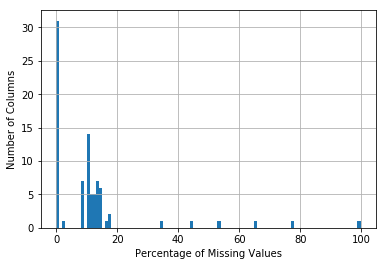

In [2426]:
# Calculate percentage of missing data in each column and plot histogram
na_prop = azdias_updated.isna().mean() * 100
plt.hist(na_prop, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.grid(True)
plt.show();

I would consider proportion of missing values above 20% 

In [2427]:
# Columns with more than 15% missing data, sorted in descending order
na_prop[na_prop >= 20].sort_values(ascending=False)


TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [2428]:
# Investigate patterns in the amount of missing data in each column
azdias_updated.isna().mean().sort_values(ascending=False).head(25)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
KBA05_GBZ         0.149597
MOBI_REGIO        0.149597
KBA05_ANTG1       0.149597
KBA05_ANTG2       0.149597
KBA05_ANTG3       0.149597
PLZ8_GBZ          0.130736
PLZ8_HHZ          0.130736
PLZ8_BAUMAX       0.130736
PLZ8_ANTG4        0.130736
PLZ8_ANTG1        0.130736
PLZ8_ANTG3        0.130736
PLZ8_ANTG2        0.130736
SHOPPER_TYP       0.124768
VERS_TYP          0.124768
HEALTH_TYP        0.124768
dtype: float64

In [2429]:
# look at basic stats of missing values counts for all 85 columns
na_count.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [2430]:
# look at basic stats of % missing values for all 85 columns
na_prop.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

Examine the percentage of missing values for attributes from each information level. 

In [2431]:
feat_info['information_level'].value_counts()

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
postcode           3
community          3
microcell_rr4      3
Name: information_level, dtype: int64

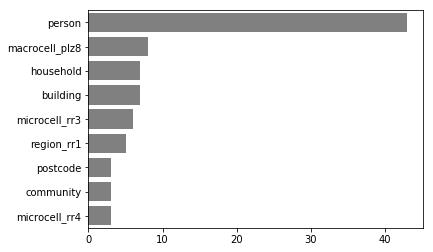

In [2432]:
# create seaborn horizontal bar plot
feature_count = feat_info['information_level'].value_counts().values
feature_level = feat_info['information_level'].value_counts().index
ax = sns.barplot(x=feature_count, y=feature_level, orient='h', color='grey')

 As we can see, about half of the features are at a person level.

In [2433]:
# create a dictionary with attribute as key and information as value
feature_dict = dict(zip(feat_info['attribute'], feat_info['information_level']))

In [2434]:
features_by_cat=[]
cat_lst=[]
for i in set(feature_dict.values()):
    cat_lst.append(i)
    features_by_cat.append([k for k,v in feature_dict.items() if v == i])

In [2435]:
# features_by_cat is a list of list, check first 2 elements
features_by_cat[:2]

[['ANZ_HAUSHALTE_AKTIV',
  'ANZ_HH_TITEL',
  'GEBAEUDETYP',
  'KONSUMNAEHE',
  'MIN_GEBAEUDEJAHR',
  'OST_WEST_KZ',
  'WOHNLAGE'],
 ['ALTER_HH',
  'ANZ_PERSONEN',
  'ANZ_TITEL',
  'HH_EINKOMMEN_SCORE',
  'KK_KUNDENTYP',
  'W_KEIT_KIND_HH',
  'WOHNDAUER_2008']]

In [2436]:
cat_lst

['building',
 'household',
 'region_rr1',
 'macrocell_plz8',
 'postcode',
 'microcell_rr4',
 'microcell_rr3',
 'community',
 'person']

In [2437]:
# Get percentage of missing values for all columns within the same category
na_percent = []
for i in range(len(cat_lst)):
    na_percent.append(azdias_updated[features_by_cat[i]].isna().mean().mean() * 100)

In [2438]:
# create dataframe for missing value percentages by feature category
cat_na_percent = pd.DataFrame(list(zip(cat_lst,na_percent)),columns=['category', 'na_percent'])
cat_na_percent.sort_values(by='na_percent', ascending=False, inplace=True)

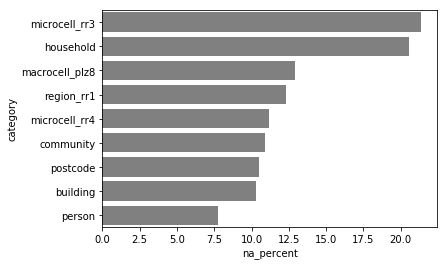

In [2439]:
# create seaborn horizontal bar plot
ax = sns.barplot(x=cat_na_percent['na_percent'], y=cat_na_percent['category'], orient='h', color='grey')

In [2440]:
cat_na_percent['na_percent']

6    21.377863
1    20.545040
3    12.923352
2    12.285640
5    11.147852
7    10.922244
4    10.518154
0    10.309772
8     7.738866
Name: na_percent, dtype: float64

The feature types microcell_rr3 and household have the most missing value percentage out of the total of 8 feature types, while building and person have the least.

In [2441]:
na_prop[na_prop >= 20].sort_values(ascending=False)

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [2442]:
outlier_cols_feat_type = []
for i in na_prop[na_prop >= 20].sort_values(ascending=False).index:
    outlier_cols_feat_type.append(feature_dict.get(i))

pd.Series(outlier_cols_feat_type).value_counts()

person           3
household        2
microcell_rr3    1
dtype: int64

In [2443]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_cols = na_prop[na_prop >= 20].index
outlier_cols

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [2444]:
azdias_updated.drop(columns=outlier_cols, inplace=True)

In [2445]:
azdias_updated.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [2446]:
remaining_cols_feat_type = []
for i in azdias_updated.columns:
    remaining_cols_feat_type.append(feature_dict.get(i))

pd.Series(remaining_cols_feat_type).value_counts()

person            40
macrocell_plz8     8
building           7
region_rr1         5
microcell_rr3      5
household          5
postcode           3
community          3
microcell_rr4      3
dtype: int64

In [2447]:
na_prop_col_drop = azdias_updated.isna().mean() * 100
na_prop_col_drop

ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 79, dtype: float64

In [2448]:
feature_cat_new = []
for sub in features_by_cat:
    feature_cat_new.append([i for i in sub if i not in outlier_cols])

In [2449]:
# Get percentage of missing values for all columns within the same category
na_percent_new = []
for i in range(len(cat_lst)):
    na_percent_new.append(azdias_updated[feature_cat_new[i]].isna().mean().mean() * 100)

In [2450]:
# create dataframe for missing value percentages by feature category
cat_na_percent_new = pd.DataFrame(list(zip(cat_lst,na_percent_new)),columns=['category', 'na_percent_new'])
cat_na_percent_new.sort_values(by='na_percent_new', ascending=False, inplace=True)

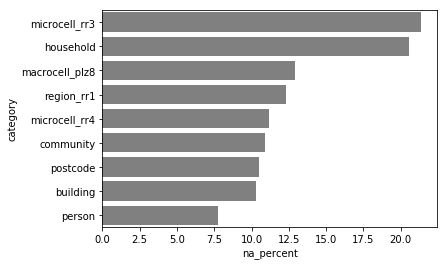

In [2451]:
# missing value percentage by feature category before removing outlier columns
ax = sns.barplot(x=cat_na_percent['na_percent'], y=cat_na_percent['category'], orient='h', color='grey')

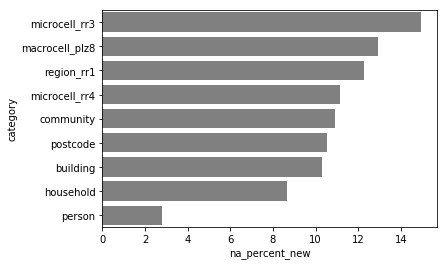

In [2452]:
# missing value percentage by feature category after removing outlier columns
ax = sns.barplot(x=cat_na_percent_new['na_percent_new'], y=cat_na_percent_new['category'], orient='h', color='grey')

In [2453]:
outlier_cols

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

After incorporating the classified missing/unknown values from feature info, the number of missing entries in the dataset went from 4,896,838 detected by Pandas to a total of 11,473,689 , an increase of nearly 6.6 million.  This accounts for about 6.2% of all entries in the entire dataset.

There is a total of 8 feature types which encompasses the 85 features in the dataset, which each individual feature being classifed as 1 of the 8 feature types.   If we examine feature type instead of feature name, we can see that features of type microcell_rr3 comprise of 14% of the missing values at a column level, followed by macrocell_plz8 and region_rr1 at 12.5% and 12% respectively.  The feature types with the lowest missing values is person at 2.3%.

20% missing values would be a reasonable cutoff in which columns will be identified as outliers.  This can be visually confirmed in the missing value percentage histogram plot with columns having more than 20% missing values being seen as outliers towards the right side.

There is a total of 6 columns which fall into the outlier category that has been removed from the dataset, which now has 79 columns.  From the 6 columns removed, 3 were of type person, 2 were of type household, and 1 was microcell_rr3.

Of the remaining 79 columns, a majority 40 belongs to type person, and the remaining 39 distributed among the other 7 feature types.  As seen from the 2 bar plots above, the missing value percentage for each feature category has drastically reduced.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

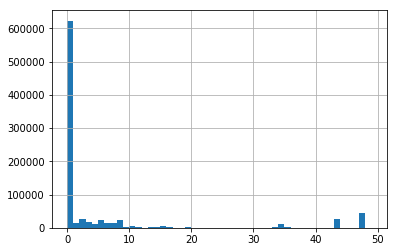

In [2454]:
# How much data is missing in each row of the dataset?
azdias_updated.isna().sum(axis=1).hist(bins=azdias_updated.isna().sum(axis=1).max())

In [2455]:
azdias_updated.isna().sum(axis=1).describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [2456]:
azdias_updated.isna().sum(axis=1).shape[0]

891221

In [2457]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# pick threshold of 2 missing row values and split the data
# Row missing value count from 0 to 2 will be the low subset, and row missing value count greater than 2 the high subset

azdias_subset_low = azdias_updated[azdias_updated.isna().sum(axis=1) <= 2]
azdias_subset_high = azdias_updated[azdias_updated.isna().sum(axis=1) > 2]

In [2458]:
azdias_subset_low.shape

(666873, 79)

In [2459]:
azdias_subset_high.shape

(224348, 79)

In [2460]:
print('Low row missing data subset count:',azdias_subset_low.shape[0])

Low row missing data subset count: 666873


In [2461]:
print('High row missing data subset count:',azdias_subset_high.shape[0])

High row missing data subset count: 224348


In [2462]:
print('High row missing data as percentage of total:',azdias_subset_high.shape[0] / (azdias_subset_low.shape[0] + azdias_subset_high.shape[0])*100)

High row missing data as percentage of total: 25.173105211838593


I consider columns with less than 0.5% missing data as having no or few missing values.  This works to be about 3000 or less missing value counts.

In [2463]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

# Find columns with no or few missing values

azdias_updated.isna().mean()[azdias_updated.isna().mean()<=0.005]

ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GREEN_AVANTGARDE         0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
ZABEOTYP                 0.000000
dtype: float64

In [2464]:
azdias_updated.isna().sum()[azdias_updated.isna().sum()<=3000]

ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GREEN_AVANTGARDE            0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
dtype: int64

In [2465]:
dict_values=[]
for i in azdias_updated.isna().sum()[azdias_updated.isna().sum()<=3000].index:
    dict_values.append(feature_dict.get(i))

print(set(dict_values))

{'person'}


Turns out these no or low missing value columns are person level features.

In [2466]:
def compare_plot(df1, df2, column):
    fig = plt.figure(10, figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Low Number Row Missing Values')
    sns.countplot(df1[column])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('High Number Row Missing Values')
    sns.countplot(df2[column])
    plt.subplots_adjust(wspace= 0.5)                                                   
    fig.suptitle(column)
    plt.show()

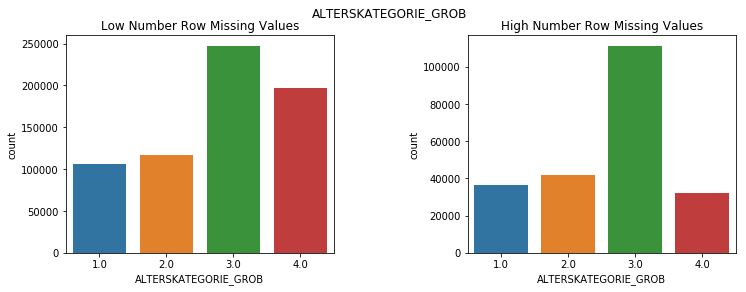

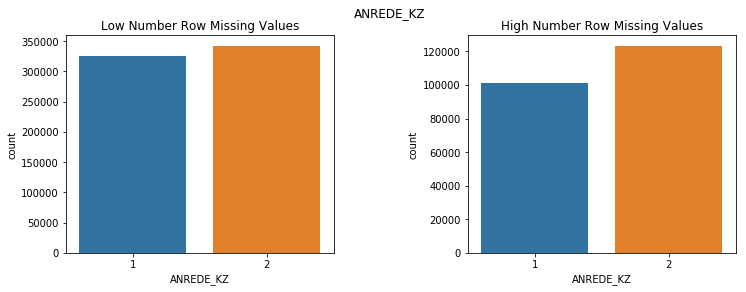

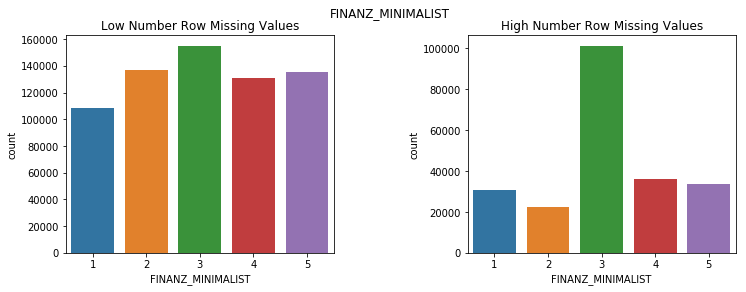

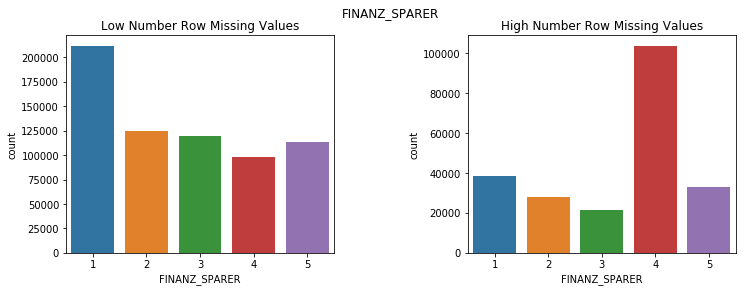

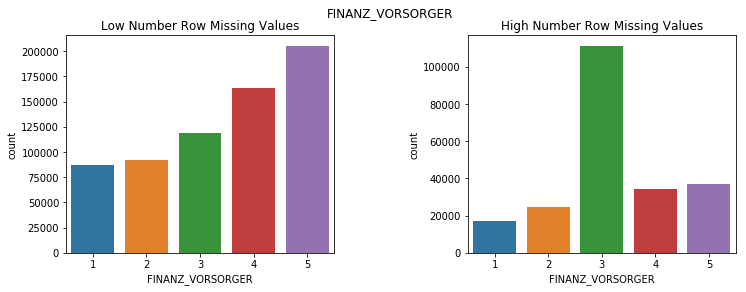

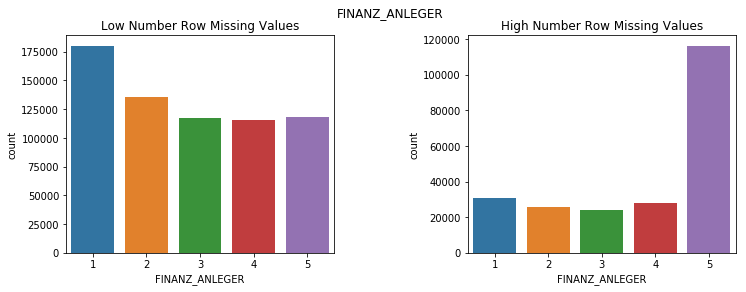

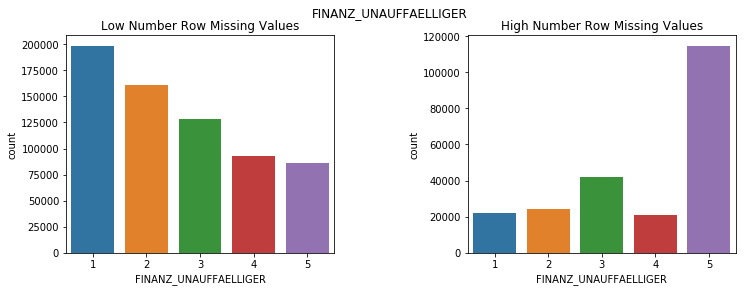

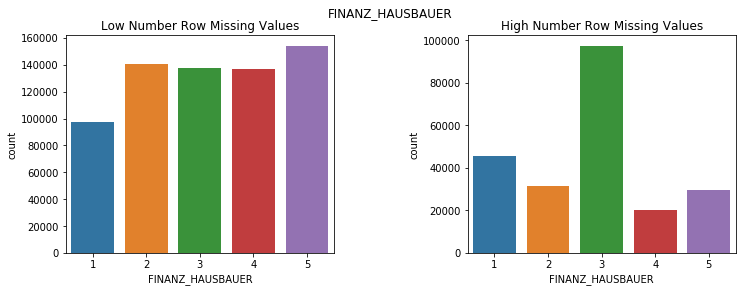

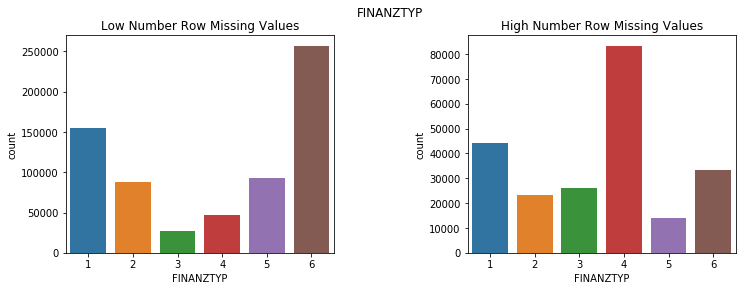

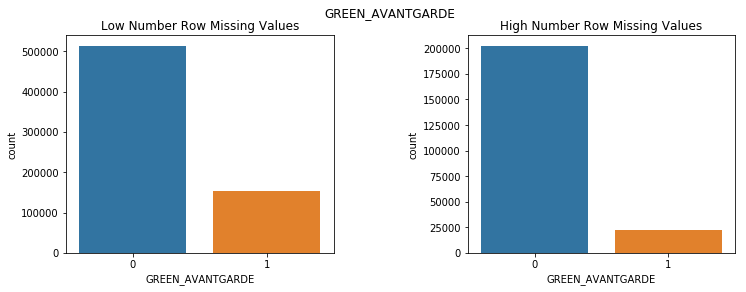

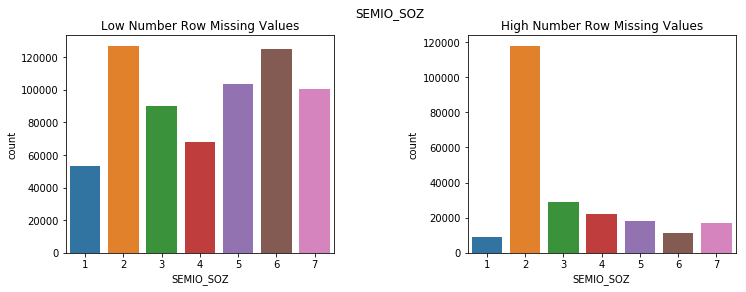

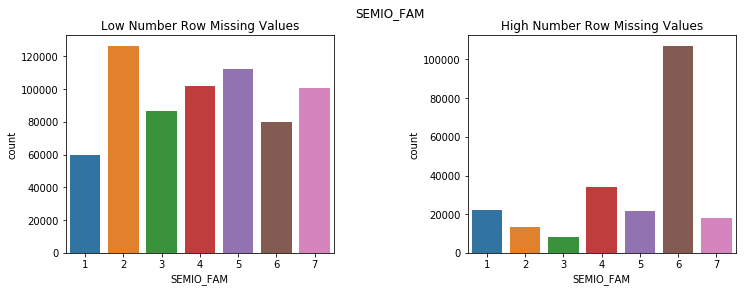

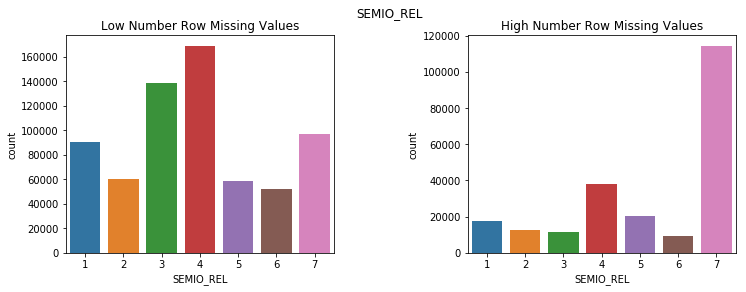

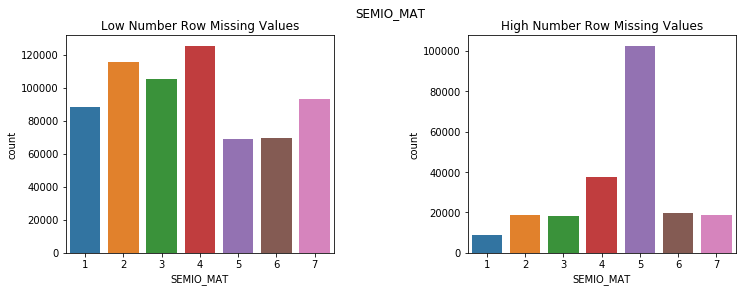

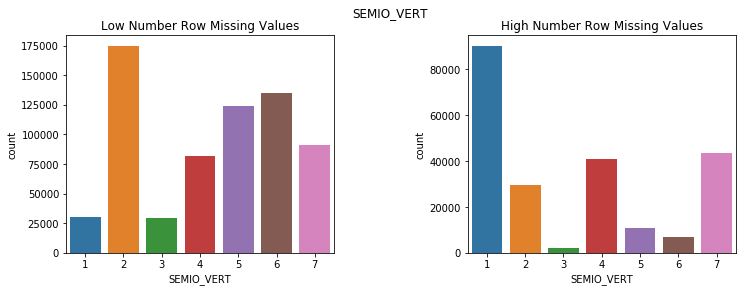

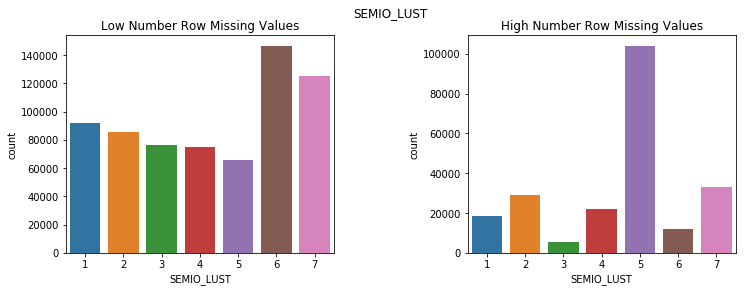

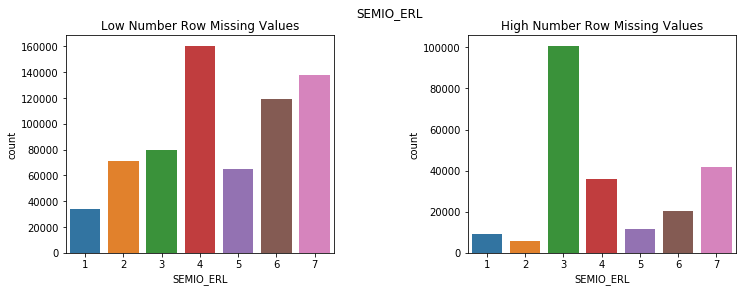

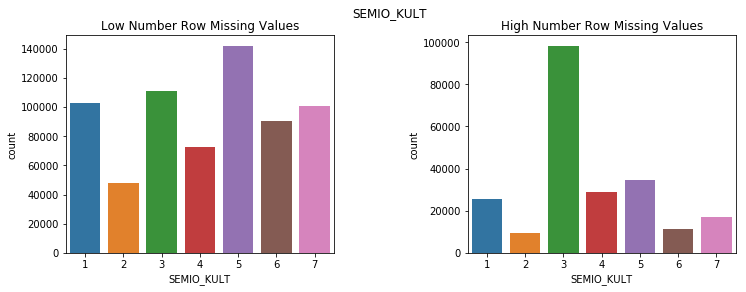

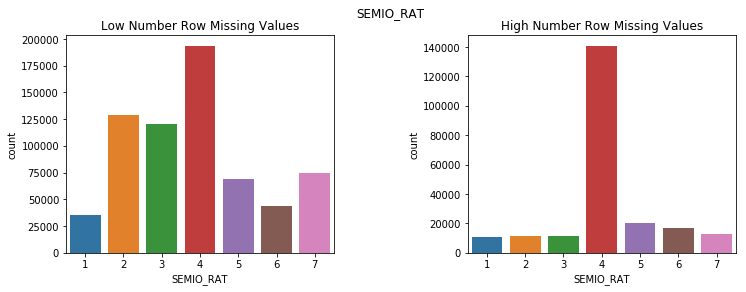

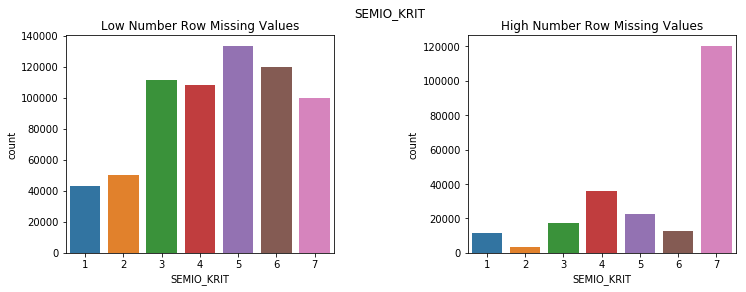

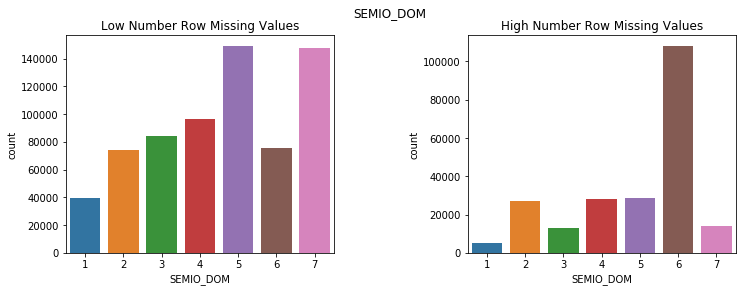

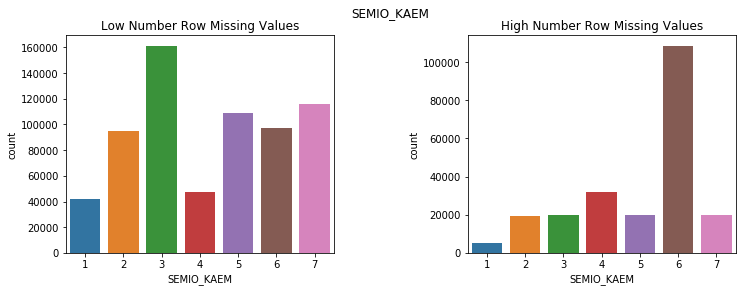

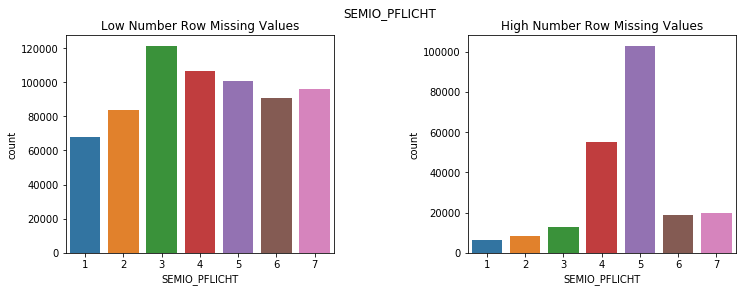

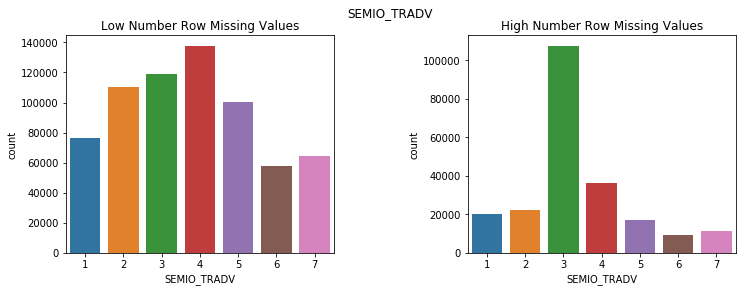

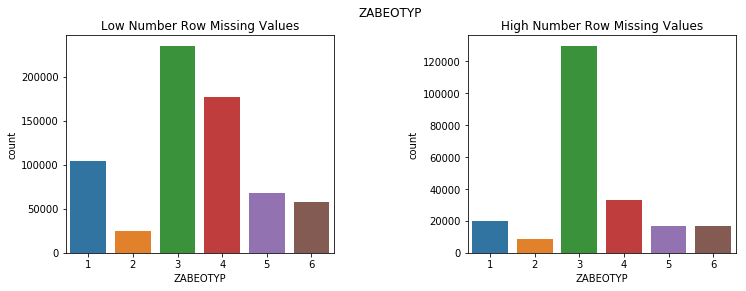

In [2467]:
compare_cols = azdias_updated.isna().sum()[azdias_updated.isna().sum()<=3000].index

for col in compare_cols:
    compare_plot(azdias_subset_low, azdias_subset_high, col)

In [2468]:
azdias_subset_high.shape[0]

224348

In [2469]:
# Drop rows with many missing values

print('rows before dropping null rows:', azdias_updated.shape[0])

azdias_updated = azdias_updated[azdias_updated.index.isin(azdias_subset_low.index)]

print('rows after dropping null rows:', azdias_updated.shape[0])

rows before dropping null rows: 891221
rows after dropping null rows: 666873


#### Discussion 1.1.3: Assess Missing Data in Each Row

I chose row missing value count of 2 as a cutoff point between the low and high subsets, and the high subset would account for 25.2%, or 224348 of 891221 rows in the dataset.

From the column missing data perspective, I chose columns with less than 0.05%, or roughly 3000 missing values to be used as the low missing value columns for the comparision charts.  I plotted all 25 columns in the comparision charts, which resulted in 25 pairs with the low and high number row missing values.

These are the features that are qualitatively similar between the data with low and high missing row values:
- ALTERSKATEGORIE_GROB
- ADREDE_KZ
- FINANZ_MINIMALIST
- FINANZ_SPARER
- GREEN_AVANTGARDE
- SEMIO_SOZ
- SEMIO_REL
- SEMIO_RAT
- ZABEOTYP

These are the features that qualitiatively different between the data with low and high missing row values:
- FINANZ_VORSORGER
- FINANZ_ANLEGER
- FINANZ_UNAUFFAELLIGER
- FINANZ_HAUSBAUER
- FINANZTYP
- SEMIO FAM
- SEMIO MAT
- SEMIO VERT
- SEMIO LUST
- SEMIO ERL
- SEMIO KULT
- SEMIO KRIT
- SEMIO DOM
- SEMIO KAEM
- SEMIO PFICHT
- SEMIO TRADV

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [2470]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [2471]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info[feat_info['type']=='categorical']['attribute']

# keep only the ones that are kept in azdias dataset
categorical_features = [i for i in categorical_features if i in azdias_updated.columns] 

In [2472]:
ordinal_features = feat_info[feat_info['type']=='ordinal']['attribute']

# keep only the ones that are kept in azdias dataset
ordinal_features = [i for i in ordinal_features if i in azdias_updated.columns] 


In [2473]:
pd.DataFrame(azdias_updated[ordinal_features].nunique(),
             columns=['num_levels']).merge(pd.DataFrame(azdias_updated[ordinal_features].dtypes,columns=['dtype']),
                                                                                        left_index=True,
                                              right_index=True).reset_index().rename(columns={'index':'ordinal_feature'})

,ordinal_feature,num_levels,dtype
0,ALTERSKATEGORIE_GROB,4,float64
1,FINANZ_MINIMALIST,5,int64
2,FINANZ_SPARER,5,int64
3,FINANZ_VORSORGER,5,int64
4,FINANZ_ANLEGER,5,int64
5,FINANZ_UNAUFFAELLIGER,5,int64
6,FINANZ_HAUSBAUER,5,int64
7,HEALTH_TYP,3,float64
8,RETOURTYP_BK_S,5,float64
9,SEMIO_SOZ,7,int64


In [2474]:
def levels(x):
    if x == 2: return 'binary'
    elif x > 2: return 'multi-level'

In [2475]:
category_features = pd.DataFrame(azdias_updated[categorical_features].nunique(),
             columns=['num_levels']).merge(pd.DataFrame(azdias_updated[categorical_features].dtypes,columns=['dtype']),
                                                                                        left_index=True,
                                              right_index=True).reset_index().rename(columns={'index':'categorical_feature'})

category_features['levels'] = cat_features['num_levels'].apply(levels)


In [2476]:
category_features

,categorical_feature,num_levels,dtype,levels
0,ANREDE_KZ,2,int64,binary
1,CJT_GESAMTTYP,6,float64,multi-level
2,FINANZTYP,6,int64,multi-level
3,GFK_URLAUBERTYP,12,float64,multi-level
4,GREEN_AVANTGARDE,2,int64,binary
5,LP_FAMILIE_FEIN,11,float64,multi-level
6,LP_FAMILIE_GROB,5,float64,multi-level
7,LP_STATUS_FEIN,10,float64,multi-level
8,LP_STATUS_GROB,5,float64,multi-level
9,NATIONALITAET_KZ,3,float64,multi-level


In [2477]:
binary = [i for i in categorical_features if azdias_updated[i].nunique() == 2]
multilevel = [i for i in categorical_features if azdias_updated[i].nunique() > 2]

In [2478]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [2479]:
azdias_updated[binary].dtypes

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object

In [2480]:
multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [2481]:
azdias_updated[multilevel].dtypes

CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
ZABEOTYP              int64
GEBAEUDETYP         float64
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

Examine OST_WEST_KZ, which is binary but is a string

In [2482]:
azdias_updated['OST_WEST_KZ'].value_counts()

W    522103
O    144770
Name: OST_WEST_KZ, dtype: int64

For OST_WEST_KZ, we will have to either convert the string values W and O to a number or encode them to dummy variables.  The other 2 binary variables ANREDE_KZ and VERS_TYP are numeric, so we can leave them as is.

In [2483]:
# encode OST_WEST_KZ
azdias_updated['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)

In [2484]:
azdias_updated['GFK_URLAUBERTYP'].value_counts()

12.0    103927
10.0     87245
8.0      73136
11.0     63597
5.0      61670
4.0      54417
3.0      46431
9.0      46236
1.0      43016
7.0      34485
2.0      30347
6.0      22366
Name: GFK_URLAUBERTYP, dtype: int64

In [2485]:
azdias_updated[multilevel].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [2486]:
azdias_updated.drop(columns=['FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015'], inplace=True)

In [2487]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Define categorical columns
cat_keep_columns = ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','LP_STATUS_GROB', 'NATIONALITAET_KZ',
                   'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']

# Create df for cat and non-cat columns
azdias_cat = azdias_updated[cat_keep_columns]
azdias_non_cat = azdias_updated.drop(columns=cat_keep_columns)

azdias_cat.dtypes

CJT_GESAMTTYP       float64
GFK_URLAUBERTYP     float64
LP_FAMILIE_GROB     float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
ZABEOTYP              int64
GEBAEUDETYP         float64
CAMEO_DEUG_2015      object
dtype: object

In [2488]:
# Implement one-hot encoding
azdias_cat = azdias_cat.astype(int)
dummies = pd.get_dummies(azdias_cat, columns=cat_keep_columns)

# concatenate column-wise 2 dataframes with 2 sets of different columns back into 1 dataframe
azdias_dummies = pd.concat([azdias_non_cat, dummies], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


Below are categorical features found in the dataset

- `CJT_GESAMTTYP`: Customer-Journey-Typology: preferred information and buying channels for consumer
- `FINANZTYP`: Most descriptive financial type for individual
- `GFK_URLAUBERTYP`: Vacation habits
- `LP_FAMILIE_FEIN`: Family type, fine scale
- `LP_FAMILIE_GROB`: Family type, rough scale
- `LP_STATUS_FEIN`: Social status, fine scale
- `LP_STATUS_GROB`: Social status, rough scale
- `NATIONALITAET_KZ`: Nationality based on given name analysis
- `SHOPPER_TYP`: Shopper typology
- `ZABEOTYP`: Energy consumption typology
- `GEBAEUDETYP`: Type of building (residential vs. commercial)
- `CAMEO_DEUG_2015`: German CAMEO: Wealth / Life Stage Typology, rough scale
- `CAMEO_DEU_201`5: German CAMEO: Wealth / Life Stage Typology, detailed scale

Columns I chose to drop

- `FINANZTYP`: This finance information has already been captured in the various FINANZ features
- `LP_FAMILIE_FEIN`: Dropped in favor of LP_FAMILIE_GROB as it has a less fine scale resulting in fewer levels.
- `LP_STATUS_FEIN`: Dropped in favor of LP_STATUS_GROB as it has a less fine scale resulting in fewer levels.
- `CAMEO_DEU_2015`: Dropped in favor of CAMEO_DEUG_2015 as it has a less fine scale resulting in fewer levels

With the 9 remaining columns I chose to use the pandas `get_dummies()` function for one-hot encoding. This would add additional number of columns equal to the sum of all the levels in the 9 categorical features.  I did the encoding on the 9 columns subset of `azdias_updated`, and then did a column-wise concatenation with the remaining non-categorical columns in azdias_updated 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [2489]:
azdias_dummies['PRAEGENDE_JUGENDJAHRE'].dtypes

dtype('float64')

In [2490]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dummies['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  9.,  6.,  5.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [2491]:
# Create new variable MAINSTREAM_AVANTGARDE and encode mainstream as 1 and avantgarde as 0

# Values corresponding to mainstream in PRAEGENDE_JUGENDJAHRE
mainstream = [1, 3, 5, 8, 10, 12, 14]

# Create MAINSTREAM_AVANTGARDE and encode 
azdias_dummies['MAINSTREAM_AVANTGARDE'] = np.where(azdias_dummies['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 1)


In [2492]:
azdias_dummies['PRAEGENDE_JUGENDJAHRE'].isna().value_counts()

False    660531
True       6342
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [2493]:
# Encode decade - 1 for 40's, 2 for 50's, 3 for 60's etc.
decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
               11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

azdias_dummies['DECADE'] = azdias_dummies['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)

In [2494]:
azdias_dummies['DECADE'].isna().value_counts()

False    660531
True       6342
Name: DECADE, dtype: int64

In [2495]:
azdias_dummies['DECADE'].value_counts()

90.0    191736
70.0    149710
80.0    127996
60.0    102305
50.0     65992
40.0     22792
Name: DECADE, dtype: int64

In [2496]:
azdias_dummies['DECADE'].dtype

dtype('float64')

In [2497]:
# drop PRAEGENDE_JUGENDJAHRE column
azdias_dummies.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

In [2498]:
azdias_dummies['DECADE'].value_counts()

90.0    191736
70.0    149710
80.0    127996
60.0    102305
50.0     65992
40.0     22792
Name: DECADE, dtype: int64

In [2499]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dummies['CAMEO_INTL_2015'].value_counts()


51    115237
41     78665
24     77496
14     53024
43     48585
54     39712
25     33724
22     26766
45     22982
13     21886
55     20441
23     17935
52     17431
34     15763
15     14859
31     14009
44     12666
12     10063
35      8861
32      8693
33      8075
Name: CAMEO_INTL_2015, dtype: int64

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [2500]:
azdias_dummies['WEALTH'] = azdias_dummies['CAMEO_INTL_2015'].str[0].astype(int)

In [2501]:
# before reverse coding
azdias_dummies['WEALTH'].value_counts(sort=False)

1     99832
2    155921
3     55401
4    162898
5    192821
Name: WEALTH, dtype: int64

In [2502]:
# Invert the wealth scale so that wealthy is 5 and poorest is 1
azdias_dummies['WEALTH'] = abs(azdias_dummies['WEALTH'] - (azdias_dummies['WEALTH'].max() + 1))

azdias_dummies['LIFE_STAGE'] = azdias_dummies['CAMEO_INTL_2015'].str[1].astype(int)

# Drop CAMEO_INTL_215 column
azdias_dummies.drop(columns=['CAMEO_INTL_2015'], inplace=True)

In [2503]:
# check to see if reverse coding worked correctly
azdias_dummies['WEALTH'].value_counts(sort=False)

1    192821
2    162898
3     55401
4    155921
5     99832
Name: WEALTH, dtype: int64

In [2504]:
azdias_dummies['LIFE_STAGE'].value_counts()

1    207911
4    198661
5    100867
3     96481
2     62953
Name: LIFE_STAGE, dtype: int64

In [2505]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


Remaining mixed-type variables are as follows.
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- WOHNLAGE
- KBA05_BAUMAX
- PLZ8_BAUMAX

In [2506]:
azdias_dummies['WOHNLAGE'].value_counts()

3.0    214424
7.0    144839
4.0    114962
2.0     85596
5.0     60901
1.0     37895
8.0      8240
0.0        16
Name: WOHNLAGE, dtype: int64

In [2507]:
# replace 7, 8 with np.nan because rural flag have been captured in another variable BALLRAUM
azdias_dummies['WOHNLAGE'].replace([7,8,0], np.nan, inplace=True)

# Invert the scale so that  very good neighborhood is 5 and very poor neighborhood is 1
azdias_dummies['WOHNLAGE'] = abs(azdias_dummies['WOHNLAGE'] - 6)

In [2508]:
# Drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, and PLZ8_BAUMAX columns
azdias_dummies.drop(columns=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For `PRAEGENDE_JUGENDJAHRE`, I created a new variable `DECADE` which encoded the 1 to 15 according to the decade, 1 for 40's, 2 for 50's, 3 for 60's etc.  `DECADE` would have the 1950s represented as numeric value 50 and 1960s as 60, and so forth.  I also created a new variable `MAINSTREAM_AVANTGARDE` where mainstream is 0 and avantgarde is 1.  Finally I dropped the original column `PRAEGENDE_JUGENDJAHRE`.

For `CAMEO_INTL_2015`, I created new variables `WEALTH` and `LIFE_STAGE`.  The tens digit of `CAMEO_INTL_2015` was assigned to `WEALTH`.  The ones digit was assigned to `LIFE_STAGE` as left as is. Finally I dropped the original column `CAMEO_INTL_2015`.  

Note that I also inverted the `WEALTH` scale so that 5 represented the highest wealth and 1 represented the poorest because I felt that this made more sense and is easier to understand.  I did the same reverse scaling to other features in the dataset that exhibited this kind of pattern (see Discussion 1.2.3)

Of the remaining mixed-type variables, I decided to retain `WOHNLAGE` because I felt that this information was not captured in any of the other variables and would be useful for the analysis.  However, I removed the values 7 and 8 as they were rural neighborhood indicators, and was already captured in the variable `BALLRAUM`, which is the distance to the nearest urban center. 

I dropped `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` because this information was caputred in the `FINANZ` variables.  I also chose not to keep PLZ8_BAUMAX because there were plenty of other features in the same group.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [2509]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info[feat_info['type']=='ordinal']['attribute']

1      ALTERSKATEGORIE_GROB
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
14               HEALTH_TYP
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
46       HH_EINKOMMEN_SCORE
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
53              KONSUMNAEHE
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP

There is a total of 49 ordinal features where the order of the feature scale matters.  Some of them are reverse scaled.  For example, FINANZ_MINIMIALIST has 1 for very high, 2 for high, 3 for average, 4 for low, and 5 for very low.  Feature like these need to be reverse scaled that 5 is very high and 1 is very low.  This allows for better interpretation and reduces confusion later on.  The 26 ordinal features below exhibute this pattern and will need to be reverse scaled.

- FINANZ_MINIMALIST (low financial interest): 1 = 'very high', 5 = 'very low'
- FINANZ_SPARER (money-saver): 1 = 'very high', 5 = 'very low'
- FINANZ_VORSORGER (be prepared): 1 = 'very high', 5 = 'very low'
- FINANZ_ANLEGER (investor): 1 = 'very high', 5 = 'very low'
- FINANZ_UNAUFFAELLIGER (inconspicuous): 1 = 'very high', 5 = 'very low'
- FINANZ_HAUSBAUER (home ownership): 1 = 'very high', 5 = 'very low'
- RETOURTYP_BK_S (Return type): 1 = 'influenceable Crazy-Shopper', 5 = 'determined Minimal-Returner'
- SEMIO_SOZ (socially-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_FAM (family-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_REL (religious): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_MAT (materialistic): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_VERT (dreamful): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_LUST (sensual-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_ERL (event-oriented): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_KULT (cultural-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_RAT (rational): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_KRIT (critical-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_DOM (dominant-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_KAEM (combative attitude): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_PFLICHT (dutiful): 1 = 'highest affinity', 7 = 'lowest affinity'
- SEMIO_TRADV (traditional-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- HH_EINKOMMEN_SCORE (Estimated household income): 1 = 'highest income', 6 = 'very low income'
- W_KEIT_KIND_HH (Likelihood of children): 1 = 'most likely', 6 = 'very unlikely'
- KKK (purchasing power): 1 = 'very high', 4 = 'low'
- MOBI_REGIO (movement patterns): 1 = 'very high movement', 6 = 'none'
- REGIOTYP (neighborhood typology): 1 = 'upper class', 7 = 'marginal groups'

In [2510]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Capture reverse-coded columns
reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 
                 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KKK', 'MOBI_REGIO', 'REGIOTYP']

# Check range for each (i.e. is the full range of values captured?)
#azdias_dummies[reverse_coded].max() - azdias_dummies[reverse_coded].min()


In [2511]:
azdias_dummies.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'MAINSTREAM_AVANTGARDE', 'DECADE', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=122)

In [2512]:
# Since some columns have been dropped previously during data wrangling
# check current columns list against reverse coded list, and update reverse_coded to include columns that exist 
# in azdias_dummies

reverse_coded = [i for i in azdias_dummies.columns if i in reverse_coded]
len(reverse_coded)

26

In [2513]:
# Check range for each (i.e. is the full range of values captured?)
azdias_dummies[reverse_coded].max()

FINANZ_MINIMALIST        5.0
FINANZ_SPARER            5.0
FINANZ_VORSORGER         5.0
FINANZ_ANLEGER           5.0
FINANZ_UNAUFFAELLIGER    5.0
FINANZ_HAUSBAUER         5.0
RETOURTYP_BK_S           5.0
SEMIO_SOZ                7.0
SEMIO_FAM                7.0
SEMIO_REL                7.0
SEMIO_MAT                7.0
SEMIO_VERT               7.0
SEMIO_LUST               7.0
SEMIO_ERL                7.0
SEMIO_KULT               7.0
SEMIO_RAT                7.0
SEMIO_KRIT               7.0
SEMIO_DOM                7.0
SEMIO_KAEM               7.0
SEMIO_PFLICHT            7.0
SEMIO_TRADV              7.0
HH_EINKOMMEN_SCORE       6.0
W_KEIT_KIND_HH           6.0
KKK                      4.0
MOBI_REGIO               6.0
REGIOTYP                 7.0
dtype: float64

In [2514]:
azdias_dummies[reverse_coded].min()

FINANZ_MINIMALIST        1.0
FINANZ_SPARER            1.0
FINANZ_VORSORGER         1.0
FINANZ_ANLEGER           1.0
FINANZ_UNAUFFAELLIGER    1.0
FINANZ_HAUSBAUER         1.0
RETOURTYP_BK_S           1.0
SEMIO_SOZ                1.0
SEMIO_FAM                1.0
SEMIO_REL                1.0
SEMIO_MAT                1.0
SEMIO_VERT               1.0
SEMIO_LUST               1.0
SEMIO_ERL                1.0
SEMIO_KULT               1.0
SEMIO_RAT                1.0
SEMIO_KRIT               1.0
SEMIO_DOM                1.0
SEMIO_KAEM               1.0
SEMIO_PFLICHT            1.0
SEMIO_TRADV              1.0
HH_EINKOMMEN_SCORE       1.0
W_KEIT_KIND_HH           1.0
KKK                      1.0
MOBI_REGIO               1.0
REGIOTYP                 1.0
dtype: float64

We can see that these features all have lowest value of 1 and highest value ranging from 5 to 7.  I will take the absolute value of [feature_value - (max(feature_value) + 1)] to reverse code it.

In [2515]:
# make copy of df
azdias_consistent_code = azdias_dummies.copy()

# reverse code columns in reverse_coded by taking absolute value of (column_value - max(column_value) + 1)
azdias_consistent_code[reverse_coded] = abs(azdias_consistent_code[reverse_coded] - (azdias_consistent_code[reverse_coded].max() + 1))

In [2516]:
azdias_dummies[reverse_coded].dtypes

FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
HH_EINKOMMEN_SCORE       float64
W_KEIT_KIND_HH           float64
KKK                      float64
MOBI_REGIO               float64
REGIOTYP                 float64
dtype: object

In [2517]:
azdias_consistent_code[reverse_coded].dtypes

FINANZ_MINIMALIST        float64
FINANZ_SPARER            float64
FINANZ_VORSORGER         float64
FINANZ_ANLEGER           float64
FINANZ_UNAUFFAELLIGER    float64
FINANZ_HAUSBAUER         float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                float64
SEMIO_FAM                float64
SEMIO_REL                float64
SEMIO_MAT                float64
SEMIO_VERT               float64
SEMIO_LUST               float64
SEMIO_ERL                float64
SEMIO_KULT               float64
SEMIO_RAT                float64
SEMIO_KRIT               float64
SEMIO_DOM                float64
SEMIO_KAEM               float64
SEMIO_PFLICHT            float64
SEMIO_TRADV              float64
HH_EINKOMMEN_SCORE       float64
W_KEIT_KIND_HH           float64
KKK                      float64
MOBI_REGIO               float64
REGIOTYP                 float64
dtype: object

In [2518]:
azdias_consistent_code.isna().sum().sum()

224682

#### Discussion 1.2.3: Complete Feature Selection

There are a total of 49 ordinal features where the order of the feature scale matters.  Some of them are reverse scaled.  For example, `FINANZ_MINIMIALIST` has 1 for very high, 2 for high, 3 for average, 4 for low, and 5 for very low.  Feature like these need to be reverse scaled that 5 is very high and 1 is very low.  This allows for better interpretation and reduces confusion later on.  The 26 ordinal features below exhibute this pattern and will need to be reverse scaled.

We can see that these features all have lowest value of 1 and highest value ranging from 5 to 7. I took the absolute value of [feature_value - (max(feature_value) + 1)] to reverse code it.

I made a copy of `azdias_dummies` and named it `azdias_consistent_code` which now contains the ordinal features that have been reverse coded.  I noticed that many of the reverse coded variables dtype that were int64 is now float64, so I converted these back to int64 to match what they were previously.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2519]:
# store subset of columns to update in replace_minus1_cols

replace_minus1_cols = feat_info[feat_info['missing_or_unknown'].str.contains('-1')]['attribute'].tolist()

In [2520]:
# store subset of columns to update in replace_zero_cols
replace_zero_cols = feat_info[feat_info['missing_or_unknown'].str.contains('0')]['attribute'].tolist()

In [2521]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    start_time=time.time()
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # columns to replace -1 with np.nan
    replace_minus1_cols = feat_info[feat_info['missing_or_unknown'].str.contains('-1')]['attribute'].tolist()
    
    # columns to replace 0 with np.nan
    replace_zero_cols = feat_info[feat_info['missing_or_unknown'].str.contains('0')]['attribute'].tolist()
    
    # columns to replace X or XX with np.nan
    replace_x_cols = feat_info[(feat_info['missing_or_unknown'].str.contains('X')) | 
                          (feat_info['missing_or_unknown'].str.contains('XX'))]['attribute'].tolist()
    
    # columns to replace 9 with np.nan
    replace_9_cols = feat_info[feat_info['missing_or_unknown'].str.contains('9')]['attribute'].tolist()
    
    
    # Replace all -1 in azdias[replace_minus1_cols] with np.nan
    df[replace_minus1_cols] = df[replace_minus1_cols].replace(-1, np.nan)

    # Replace all 0 in azdias[replace_zero_cols] with np.nan
    df[replace_zero_cols] = df[replace_zero_cols].replace(0, np.nan)
    
    # Replace 9 in azdias[replace_9_cols] with np.nan
    df[replace_x_cols] = df[replace_x_cols].replace(['X','XX'], np.nan)

    # Replace 9 in azdias[replace_9_cols] with np.nan
    df[replace_9_cols] = df[replace_9_cols].replace(9, np.nan)
    
    
    # remove selected columns and rows, ...
    # Remove columns with 20% or more missing values
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(columns=outlier_cols, inplace=True)
    
    # Remove rows with greater than 2 missing values
    
    # define missing low and high subsets
    df_subset_low = df[df.isna().sum(axis=1) <= 2]
    df_subset_high = df[df.isna().sum(axis=1) > 2]
    df = df[df.index.isin(df_subset_low.index)]
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)
    df.drop(columns=['FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015'], inplace=True)
    
    # Define categorical columns
    cat_keep_columns = ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','LP_STATUS_GROB', 'NATIONALITAET_KZ',
                   'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
    # Create df for cat and non-cat columns
    df_cat = df[cat_keep_columns]
    df_non_cat = df.drop(columns=cat_keep_columns)  
    
    # Implement one-hot encoding using pd.get_dummies()
    df_cat = df_cat.astype(int)
    dummies = pd.get_dummies(df_cat, columns=cat_keep_columns)
    df_dummies = pd.concat([df_non_cat, dummies], axis=1)

    # Values corresponding to mainstream in PRAEGENDE_JUGENDJAHRE
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    
    # Create new variable MAINSTREAM_AVANTGARDE and encode mainstream as 1 and avantgarde as 0
    df_dummies['MAINSTREAM_AVANTGARDE'] = np.where(df_dummies['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 1)
    
    # Encode decade - 1 for 40's, 2 for 50's, 3 for 60's etc.    
    decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
                   11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

    # Create new DECADE feature with above encoding from PRAEGENDE_JUGENDJAHRE
    df_dummies['DECADE'] = df_dummies['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)

    # Create new WEALTH and LIFE_STAGE features from CAMEO_INTL_2015
    df_dummies['WEALTH'] = df_dummies['CAMEO_INTL_2015'].str[0].astype(int)
    df_dummies['LIFE_STAGE'] = df_dummies['CAMEO_INTL_2015'].str[1].astype(int)
    
    # Invert the wealth scale so that wealthy is 5 and poorest is 1
    df_dummies['WEALTH'] = abs(df_dummies['WEALTH'] - (df_dummies['WEALTH'].max() + 1))
    
    # Keep mixed-type feature WOHNLAGE and drop remaining mixed-type features
    # Replace 7, 8 with np.nan because rural flag have been captured in another variable BALLRAUM
    df_dummies['WOHNLAGE'].replace([7,8,0], np.nan, inplace=True)

    # Invert the scale so that  very good neighborhood is 5 and very poor neighborhood is 1
    df_dummies['WOHNLAGE'] = abs(df_dummies['WOHNLAGE'] - (df_dummies['WOHNLAGE'].max() + 1))

    # Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns
    df_dummies.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    df_dummies.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    # Drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, and PLZ8_BAUMAX columns
    df_dummies.drop(columns=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], inplace=True)
    
    # Make copy of df_dummies
    df_consistent_code = df_dummies.copy()
    
    # Reverse code columns in reverse_coded by taking absolute value of (column_value - max(column_value) + 1)
    # Capture reverse-coded columns
    reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 
                 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KKK', 'MOBI_REGIO', 'REGIOTYP']
    
    # Since some columns have been dropped previously during data wrangling
    # check current columns list against reverse coded list, and update reverse_coded to include columns that exist 
    # in df_dummies
    reverse_coded_cols = [i for i in df_dummies.columns if i in reverse_coded]
    
    df_consistent_code[reverse_coded_cols] = abs(df_consistent_code[reverse_coded_cols] -
                                                 (df_consistent_code[reverse_coded_cols].max() + 1))
    
    print('runtime:',round((time.time() - start_time),3),'seconds')
    
    # Return the cleaned dataframe
    return df_consistent_code

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [2522]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_consistent_code.isna().sum().sum()

224682

In [2523]:
azdias_consistent_code.isna().sum()[azdias_consistent_code.isna().sum() > 0]

W_KEIT_KIND_HH           7421
ANZ_HAUSHALTE_AKTIV      1812
KONSUMNAEHE                34
WOHNLAGE               153095
GEBAEUDETYP_RASTER          2
KKK                     27656
REGIOTYP                27656
KBA13_ANZAHL_PKW          528
ARBEIT                     68
RELAT_AB                   68
DECADE                   6342
dtype: int64

In [2524]:
azdias_consistent_code[azdias_consistent_code.isna().sum()[azdias_consistent_code.isna().sum() > 0].index].dtypes

W_KEIT_KIND_HH         float64
ANZ_HAUSHALTE_AKTIV    float64
KONSUMNAEHE            float64
WOHNLAGE               float64
GEBAEUDETYP_RASTER     float64
KKK                    float64
REGIOTYP               float64
KBA13_ANZAHL_PKW       float64
ARBEIT                 float64
RELAT_AB               float64
DECADE                 float64
dtype: object

In [2525]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

In [2526]:
# Impute the mean for missing values
azdias_imputed = imputer.fit_transform(azdias_consistent_code) 

In [2527]:
pd.DataFrame(azdias_imputed)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,1.0,2.0,5.0,1.0,4.0,1.0,2.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,90.0,1.0,1.0
1,3.0,2.0,5.0,2.0,5.0,4.0,3.0,1.0,1.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,4.0,4.0
2,3.0,1.0,2.0,3.0,2.0,5.0,3.0,4.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,70.0,2.0,3.0
3,1.0,2.0,3.0,5.0,1.0,4.0,4.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,1.0,4.0
4,2.0,2.0,5.0,1.0,5.0,1.0,2.0,3.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666868,4.0,2.0,3.0,3.0,3.0,1.0,3.0,4.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,80.0,3.0,4.0
666869,1.0,2.0,5.0,1.0,4.0,3.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,4.0,3.0
666870,2.0,2.0,5.0,1.0,4.0,2.0,1.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,80.0,3.0,1.0
666871,1.0,1.0,5.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,90.0,1.0,1.0


In [2528]:
pd.DataFrame(azdias_imputed).isna().sum().sum()

0

In [2529]:
# Apply standard scaling
azdias_standard = scaler.fit_transform(azdias_imputed) 

In [2530]:
pd.DataFrame(azdias_standard)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,-1.742284,0.974592,1.518333,-1.584388,1.052653,-1.521225,-1.046959,-1.332026,-0.546393,1.044315,...,-0.385649,-0.267525,-0.397754,-0.331366,2.160798,-0.399724,-0.561054,1.162032,-1.166730,-1.260429
1,0.193020,0.974592,1.518333,-0.905963,1.773152,0.538858,-0.320062,-1.332026,1.830185,1.044315,...,2.593029,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,1.162032,0.879379,0.748259
2,0.193020,-1.026070,-0.681366,-0.227538,-0.388344,1.225553,-0.320062,0.844853,-0.546393,1.044315,...,-0.385649,-0.267525,2.514119,-0.331366,-0.462792,-0.399724,-0.561054,-0.218147,-0.484694,0.078696
3,-1.742284,0.974592,0.051867,1.129311,-1.108842,0.538858,0.406835,-1.332026,-0.546393,1.044315,...,-0.385649,-0.267525,-0.397754,-0.331366,2.160798,-0.399724,-0.561054,-1.598326,-1.166730,0.748259
4,-0.774632,0.974592,1.518333,-1.584388,1.773152,-1.521225,-1.046959,0.119227,-0.546393,-0.279180,...,2.593029,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,-0.561054,0.471943,0.879379,-0.590866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666868,1.160672,0.974592,0.051867,-0.227538,0.332155,-1.521225,-0.320062,0.844853,1.830185,-1.602675,...,-0.385649,3.737974,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,0.471943,0.197342,0.748259
666869,-1.742284,0.974592,1.518333,-1.584388,1.052653,-0.147836,-0.320062,-0.606400,-0.546393,1.044315,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,-0.561054,1.162032,0.879379,0.078696
666870,-0.774632,0.974592,1.518333,-1.584388,1.052653,-0.834531,-1.773856,-0.606400,-0.546393,-0.279180,...,-0.385649,3.737974,-0.397754,-0.331366,-0.462792,-0.399724,-0.561054,0.471943,0.197342,-1.260429
666871,-1.742284,-1.026070,1.518333,-1.584388,0.332155,-1.521225,-1.773856,-1.332026,-0.546393,-1.602675,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,2.501727,-0.561054,1.162032,-1.166730,-1.260429


### Discussion 2.1: Apply Feature Scaling

I performed imputation on `azdias_consistent_code` to fill in the missing values with the mean the values in the column.  Atter that I performed feature scaling by applying a standard scaler to `azdias_imputed` by calling `fit_trasform` and assigning to `azdias_standard`

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [2531]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_standard)

In [2532]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_

array([1.11716943e-01, 8.51018780e-02, 5.38423406e-02, 3.52339282e-02,
       2.44572889e-02, 2.03059920e-02, 1.90085013e-02, 1.70723517e-02,
       1.56318494e-02, 1.51742290e-02, 1.40860187e-02, 1.34201332e-02,
       1.29628119e-02, 1.24958504e-02, 1.22771805e-02, 1.17793942e-02,
       1.14005738e-02, 1.12857095e-02, 1.07607715e-02, 1.06744805e-02,
       1.05915509e-02, 1.03157007e-02, 1.01112026e-02, 1.00106595e-02,
       9.89989797e-03, 9.66526801e-03, 9.57844094e-03, 9.51120438e-03,
       9.40497388e-03, 9.26267301e-03, 9.24948358e-03, 9.17786074e-03,
       9.07231175e-03, 8.97376804e-03, 8.93774363e-03, 8.82056660e-03,
       8.78346704e-03, 8.71354409e-03, 8.60693970e-03, 8.53240959e-03,
       8.48936504e-03, 8.44589512e-03, 8.39620376e-03, 8.26269249e-03,
       8.22093914e-03, 8.20341912e-03, 8.19503789e-03, 8.19105426e-03,
       8.08957441e-03, 7.93597493e-03, 7.90342483e-03, 7.84195715e-03,
       7.68988865e-03, 7.57537851e-03, 7.36939816e-03, 7.24332201e-03,
      

In [2533]:
len(pca.explained_variance_ratio_)

122

In [2534]:
def scree_plot(pca, annotate=False, limit=None, figsize=(15,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    ax.grid(True)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

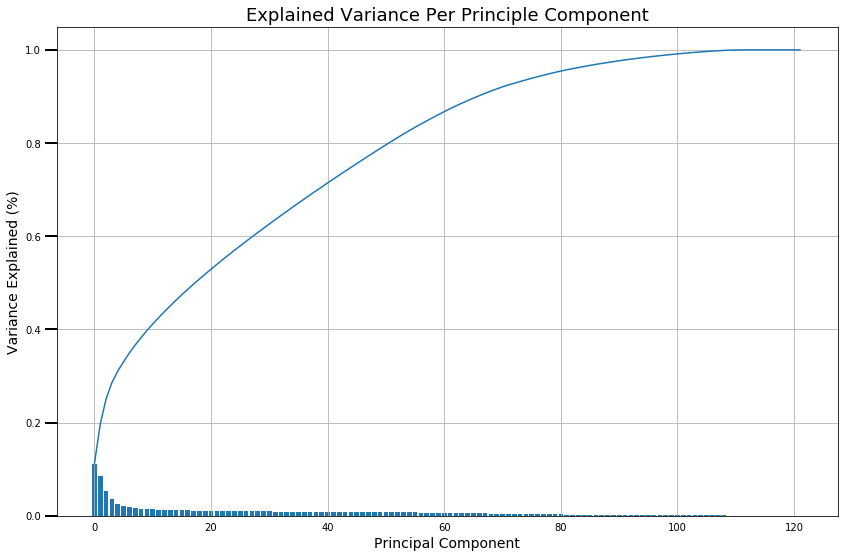

In [2535]:
scree_plot(pca, figsize=(14, 9))

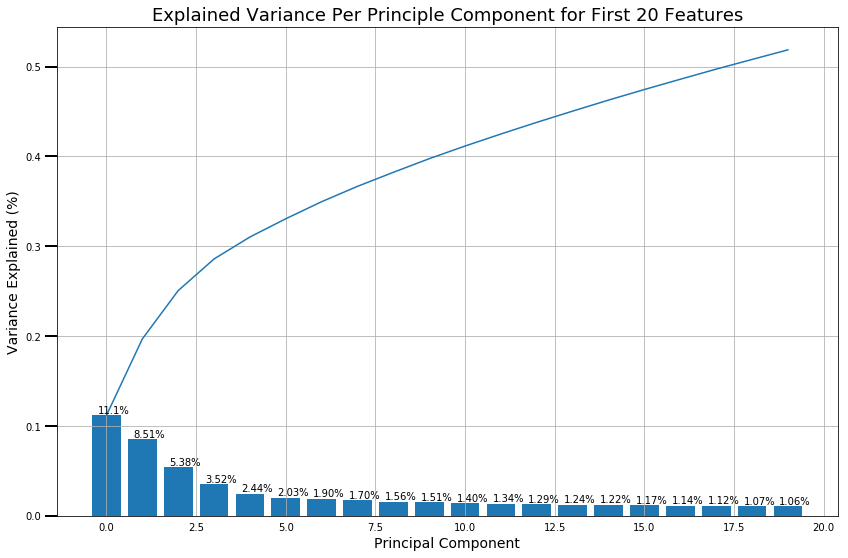

In [2536]:
scree_plot(pca, annotate=True, limit=20, figsize=(14, 9))

In [2537]:
pca.explained_variance_ratio_[:3].sum()

0.250661161739322

In [2538]:
for i in np.arange(5, 85, 5):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

For 5 components, explained variance: 0.31035237884568545
For 10 components, explained variance: 0.39754530226124407
For 15 components, explained variance: 0.46278729702605925
For 20 components, explained variance: 0.5186882264691329
For 25 components, explained variance: 0.5696172381833483
For 30 components, explained variance: 0.6170397983933127
For 35 components, explained variance: 0.6624509661328529
For 40 components, explained variance: 0.7059078931482363
For 45 components, explained variance: 0.7477229887004964
For 50 components, explained variance: 0.7883380493194355
For 55 components, explained variance: 0.826718096626283
For 60 components, explained variance: 0.8609849540892445
For 65 components, explained variance: 0.8910246723922464
For 70 components, explained variance: 0.9161960978498521
For 75 components, explained variance: 0.9355533157868652
For 80 components, explained variance: 0.9516438265525907


In [2539]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components=40)
X_pca_40 = pca_40.fit_transform(azdias_standard)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- First 3 components captured about 25% of the variance
- 50% variance captured roughly 15 and 20 components
- 75% variance captured with between 45 and 50 components
- There is a total of 122 components

I chose to retain 40 components (32.7% of all components), which gives 70.5% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [2540]:
def pca_results(full_dataset, pca, ith_comp=0, top_k=False, k=5):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    if ith_comp > 0:
        if top_k:
            return pd.concat([variance_ratios, components], axis = 1).loc['Dimension {}'.format(ith_comp)].sort_values(ascending=False).iloc[np.r_[0:k, -k:0]]
        else:
            return pd.concat([variance_ratios, components], axis = 1).loc['Dimension {}'.format(ith_comp)].sort_values(ascending=False)
    else:
        return pd.concat([variance_ratios, components], axis = 1)


In [2541]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_consistent_code, pca_40, ith_comp=1)

MOBI_REGIO            0.2172
FINANZ_MINIMALIST     0.2027
LP_STATUS_GROB_1      0.2015
PLZ8_ANTG3            0.1929
PLZ8_ANTG4            0.1877
                       ...  
WEALTH               -0.1914
HH_EINKOMMEN_SCORE   -0.1920
KBA05_GBZ            -0.1931
PLZ8_ANTG1           -0.1950
KBA05_ANTG1          -0.2034
Name: Dimension 1, Length: 123, dtype: float64

In [2542]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_consistent_code, pca_40, ith_comp=2)

ALTERSKATEGORIE_GROB    0.2376
SEMIO_REL               0.2367
FINANZ_SPARER           0.2169
SEMIO_PFLICHT           0.2145
SEMIO_TRADV             0.2140
                         ...  
SEMIO_LUST             -0.1669
ONLINE_AFFINITAET      -0.1671
SEMIO_ERL              -0.2074
FINANZ_VORSORGER       -0.2110
DECADE                 -0.2314
Name: Dimension 2, Length: 123, dtype: float64

In [2543]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_consistent_code, pca_40, ith_comp=3)

SEMIO_KAEM    0.3262
SEMIO_DOM     0.3018
SEMIO_KRIT    0.2650
SEMIO_RAT     0.1925
SEMIO_ERL     0.1805
               ...  
SEMIO_KULT   -0.2323
SEMIO_FAM    -0.2510
SEMIO_SOZ    -0.2581
SEMIO_VERT   -0.3319
ANREDE_KZ    -0.3538
Name: Dimension 3, Length: 123, dtype: float64

#### First principal component top 5 positive and negative weights

In [2544]:
pca_results(azdias_consistent_code, pca_40, ith_comp=1, top_k=True, k=5)

MOBI_REGIO            0.2172
FINANZ_MINIMALIST     0.2027
LP_STATUS_GROB_1      0.2015
PLZ8_ANTG3            0.1929
PLZ8_ANTG4            0.1877
WEALTH               -0.1914
HH_EINKOMMEN_SCORE   -0.1920
KBA05_GBZ            -0.1931
PLZ8_ANTG1           -0.1950
KBA05_ANTG1          -0.2034
Name: Dimension 1, dtype: float64

#### Second principal component top 5 positive and negative weights

In [2545]:
pca_results(azdias_consistent_code, pca_40, ith_comp=2, top_k=True, k=5)

ALTERSKATEGORIE_GROB    0.2376
SEMIO_REL               0.2367
FINANZ_SPARER           0.2169
SEMIO_PFLICHT           0.2145
SEMIO_TRADV             0.2140
SEMIO_LUST             -0.1669
ONLINE_AFFINITAET      -0.1671
SEMIO_ERL              -0.2074
FINANZ_VORSORGER       -0.2110
DECADE                 -0.2314
Name: Dimension 2, dtype: float64

#### Third principal component top 5 positive and negative weights

In [2546]:
pca_results(azdias_consistent_code, pca_40, ith_comp=3, top_k=True, k=5)

SEMIO_KAEM    0.3262
SEMIO_DOM     0.3018
SEMIO_KRIT    0.2650
SEMIO_RAT     0.1925
SEMIO_ERL     0.1805
SEMIO_KULT   -0.2323
SEMIO_FAM    -0.2510
SEMIO_SOZ    -0.2581
SEMIO_VERT   -0.3319
ANREDE_KZ    -0.3538
Name: Dimension 3, dtype: float64

### Discussion 2.3: Interpret Principal Components


##### Principle component 1: top 5 positive mapping:
- MOBI_REGIO (Movement patterns)
- FINANZ_MINIMALIST (low financial interest)
- LP_STATUS_GROB_1 (low income earners)
- PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
- PLZ8_ANTG3 (Number of 10+ family houses in the PLZ8 region)

##### Principle component 1: top 5 negative mapping:
- KBA05_ANTG1 (Number of 1-2 family houses in the microcell) 
- PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
- KBA05_GBZ (Number of buildings in the microcell)
- HH_EINKOMMEN_SCORE (Estimated household net income)
- WEALTH (Personal wealth)


##### Principle component 2: top 5 positive mapping:
- ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
- SEMIO_REL (religious)
- FINANZ_SPARER (money saver)
- SEMIO_PFLICHT (dutiful)
- SEMIO_TRADV (traditional minded)

##### Principle component 2: top 5 negative mapping:
- DECADE (Decade of dominating movement of person's youth)
- FINANZ_VORSORGER (be prepared)
- SEMIO_ERL (event-oriented)
- ONLINE_AFFINITAET (online affinity)
- SEMIO_LUST (sensual-minded)


##### Principle component 3: top 5 positive mapping:
- SEMIO_KAEM (combative attitude)
- SEMIO_DOM (dominant-minded)
- SEMIO_KRIT (critical-minded)
- SEMIO_RAT (rational)
- SEMIO_ERL (event-oriented)

##### Principle component 3: top 5 negative mapping:
- ANREDE_KZ (gender)
- SEMIO_VERT  (dreamful)
- SEMIO_SOZ  (socially-minded)
- SEMIO_FAM  (family-minded)
- SEMIO_KULT (cultural-minded)

Features that are important in principle component 1 seen in the top 5 positive and negative weights can be seen as the group of people that have low income, financial interest, move around a lot, and live in a family with many occupants.

The correlation seen with each of the principle components can be as the value of features with positive weight increase, the value of features with negative weight decreases.  For example, in the first principle component, we hgave a positve weight feature FINANZ_MINIMALIST and negative weight feature WEALTH. if the value of FINANZ_MINIMALIST increases, then the value of WEALTH decreases, which makes sense.  The same goes for 2nd and 3rd principle components.

#### Principle component 1
Principle component 1 describes people with lower income segment of the population that move around a lot and live in a house with more than 6 people in it.  This contrasts with a more wealthy population segment that live in a house with less occupants.


#### Principle component 2
Principle component 2 describes people that are older, more religious, money savers and often traditional minded.  This contrasts with a younger population seen in the negative mapping that are event oriented and may have a financial mindset to need to be prepared.


#### Principle component 3
Principle component 3 describes people with a strong and dominant personality that are often critical minded with combative attitude.  This contrasts with those that are socially, family , and culturally minded.  I noticed that there is a gender feature here.  This would also describe male vs female traits.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [2869]:
# Run k-means clustering on the data

def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [195]:
# Run k-means clustering by calling k_mean_score function iterated over a cluster count from 1 to 40
start_time=time.time()  

scores_40 = []
ks = list(range(1,41))

for k in ks:
    iteration_start=time.time()  
    
    # Compute the average within-cluster distances and append to score list.
    scores_40.append(k_mean_score(X_pca_40, k))
    
    print('cluster',k,'score calculated. Runtime:',round((time.time() - iteration_start),2),'s  Total time:',
         round((time.time() - start_time),2),'s')
    
print(' ')    
print('total running time:',round((time.time() - start_time),2),'s')   

cluster 1 score calculated. Runtime: 7.19 s  Total time: 7.19 s
cluster 2 score calculated. Runtime: 27.33 s  Total time: 34.52 s
cluster 3 score calculated. Runtime: 55.13 s  Total time: 89.66 s
cluster 4 score calculated. Runtime: 46.71 s  Total time: 136.37 s
cluster 5 score calculated. Runtime: 78.2 s  Total time: 214.58 s
cluster 6 score calculated. Runtime: 103.98 s  Total time: 318.55 s
cluster 7 score calculated. Runtime: 98.79 s  Total time: 417.35 s
cluster 8 score calculated. Runtime: 117.11 s  Total time: 534.47 s
cluster 9 score calculated. Runtime: 191.31 s  Total time: 725.78 s
cluster 10 score calculated. Runtime: 204.36 s  Total time: 930.14 s
cluster 11 score calculated. Runtime: 231.34 s  Total time: 1161.49 s
cluster 12 score calculated. Runtime: 258.19 s  Total time: 1419.68 s
cluster 13 score calculated. Runtime: 276.06 s  Total time: 1695.74 s
cluster 14 score calculated. Runtime: 304.19 s  Total time: 1999.93 s
cluster 15 score calculated. Runtime: 375.55 s  Tot

In [196]:
scores_40

[57146626.95374935,
 50244827.02395059,
 46752763.15832991,
 44669765.53421689,
 43259585.45440686,
 42044151.9904591,
 40949212.330624685,
 40088199.345406845,
 39458616.58666249,
 38889999.99126618,
 38463256.06965174,
 38077009.286768444,
 37578295.47644244,
 37229201.94870636,
 36959853.05760477,
 36608584.18194629,
 36315323.63552544,
 36089499.09018349,
 35818536.77324234,
 35628729.46348731,
 35408102.29796406,
 35185252.93282863,
 35014997.86701712,
 34825815.49677493,
 34677796.489313,
 34490144.2995203,
 34362210.860617064,
 34195322.302203074,
 33993851.62254701,
 33868506.23119259,
 33796542.34784859,
 33683716.32432559,
 33522704.25438873,
 33409285.25118226,
 33326198.01296172,
 33204785.573952068,
 33068738.204764433,
 33009001.83191159,
 32892626.016816683,
 32760643.7865481]

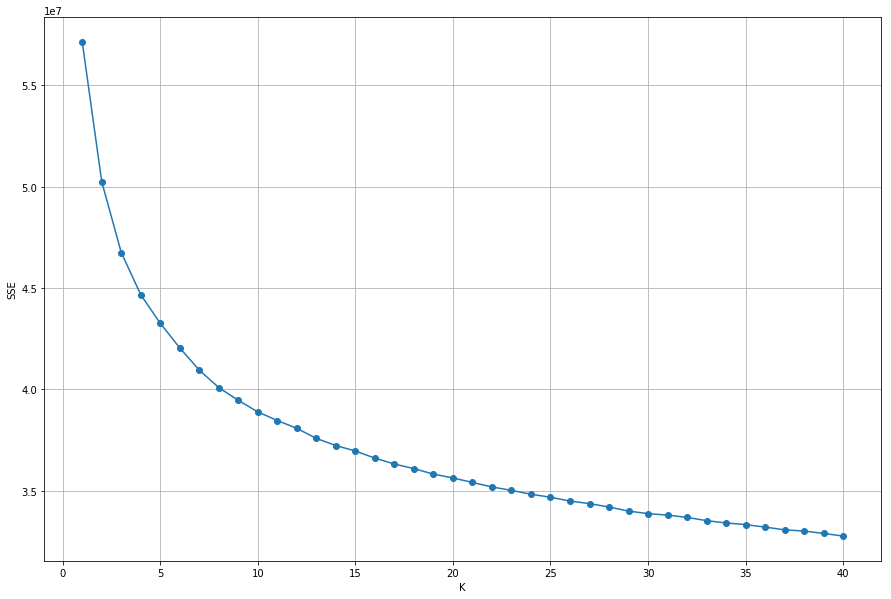

In [305]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,10))
plt.plot(ks, scores_40, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid(True)

In [306]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time=time.time()
kmeans_13 = KMeans(n_clusters=13).fit(X_pca_40)
print('Runtime:',round((time.time() - start_time),2),'s')

Runtime: 307.82 s


### Discussion 3.1: Apply Clustering to General Population
From the chart above, the elblow seems to be located between 10 and 15 for the value of K.  Hence, I will be using K=13 for the number of clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [1796]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [1797]:
customers.shape

(191652, 85)

In [1798]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = customers.copy()
customers_clean = clean_data(customers_clean)

runtime: 2.901 seconds


In [1799]:
customers_clean.shape

(122116, 121)

In [1800]:
customers_clean.isna().sum().sum()

41265

In [1801]:
customers_clean.isna().sum().sort_values(ascending=False)

WOHNLAGE                29285
REGIOTYP                 5468
KKK                      5468
W_KEIT_KIND_HH            516
DECADE                    323
                        ...  
LP_STATUS_GROB_1            0
LP_STATUS_GROB_2            0
LP_STATUS_GROB_3            0
LP_STATUS_GROB_4            0
ALTERSKATEGORIE_GROB        0
Length: 121, dtype: int64

In [1802]:
# Find difference in columns between azdias and customers df
list(set(azdias_consistent_code.columns) - set(customers_clean.columns))

['GEBAEUDETYP_5']

In [1803]:
azdias_consistent_code.columns.get_loc('GEBAEUDETYP_5')

106

In [1804]:
# Insert missing column in customers back into df in the same order as azdias, and assign all values to 0
customers_clean.insert(azdias_consistent_code.columns.get_loc('GEBAEUDETYP_5'), 'GEBAEUDETYP_5', 0)

In [1805]:
customers_clean.iloc[:,azdias_consistent_code.columns.get_loc('GEBAEUDETYP_5')].value_counts()

0    122116
Name: GEBAEUDETYP_5, dtype: int64

In [1806]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM_AVANTGARDE,DECADE,WEALTH,LIFE_STAGE
0,4.0,1,1.0,5.0,1.0,5.0,4.0,4.0,1,1.0,...,0,0,0,0,0,0,1,50.0,5,3
2,4.0,2,1.0,5.0,1.0,5.0,2.0,2.0,1,2.0,...,0,1,0,0,0,0,1,50.0,3,4
4,3.0,1,3.0,5.0,2.0,2.0,1.0,4.0,0,3.0,...,0,0,0,1,0,0,0,70.0,2,1
5,3.0,1,1.0,5.0,1.0,5.0,4.0,3.0,1,3.0,...,0,1,0,0,0,0,1,50.0,3,4
6,4.0,1,1.0,5.0,1.0,5.0,5.0,4.0,1,2.0,...,0,0,0,0,0,0,1,50.0,4,3


In [1807]:
customers_clean.isna().sum().sum()

41265

In [1808]:
# Perform the same imputing done on azdias for customer dataset by calling transform function on imputer
customers_imputed = imputer.transform(customers_clean)

In [1809]:
# See what customers_imputed df looks like
pd.DataFrame(customers_imputed)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,4.0,1.0,1.0,5.0,1.0,5.0,4.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,5.0,3.0
1,4.0,2.0,1.0,5.0,1.0,5.0,2.0,2.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.0,3.0,4.0
2,3.0,1.0,3.0,5.0,2.0,2.0,1.0,4.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,70.0,2.0,1.0
3,3.0,1.0,1.0,5.0,1.0,5.0,4.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.0,3.0,4.0
4,4.0,1.0,1.0,5.0,1.0,5.0,5.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122111,2.0,2.0,4.0,5.0,1.0,5.0,4.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,5.0,4.0
122112,3.0,1.0,1.0,5.0,1.0,5.0,5.0,4.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,5.0,4.0
122113,4.0,1.0,1.0,5.0,1.0,5.0,5.0,4.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,4.0,4.0
122114,3.0,2.0,4.0,5.0,1.0,5.0,4.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,4.0,4.0


In [1810]:
# check that missing values are 0 after imputation
pd.DataFrame(customers_imputed).isna().sum().sum()

0

In [1811]:
# Standardize customer_imputed using same standard scaling done on azdias, by calling transform function on scaler
customers_standard = scaler.transform(customers_imputed)

In [1812]:
# See what customer standarized df looks like
pd.DataFrame(customers_standard)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,1.160672,-1.026070,-1.414599,1.129311,-1.108842,1.225553,0.406835,0.844853,1.830185,-1.602675,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,1.561415,0.078696
1,1.160672,0.974592,-1.414599,1.129311,-1.108842,1.225553,-1.046959,-0.606400,1.830185,-0.279180,...,-0.385649,3.737974,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,0.197342,0.748259
2,0.193020,-1.026070,0.051867,1.129311,-0.388344,-0.834531,-1.773856,0.844853,-0.546393,1.044315,...,-0.385649,-0.267525,-0.397754,3.017814,-0.462792,-0.399724,-0.561054,-0.218147,-0.484694,-1.260429
3,0.193020,-1.026070,-1.414599,1.129311,-1.108842,1.225553,0.406835,0.119227,1.830185,1.044315,...,-0.385649,3.737974,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,0.197342,0.748259
4,1.160672,-1.026070,-1.414599,1.129311,-1.108842,1.225553,1.133732,0.844853,1.830185,-0.279180,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,0.879379,0.078696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122111,-0.774632,0.974592,0.785100,1.129311,-1.108842,1.225553,0.406835,-1.332026,-0.546393,-0.279180,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,-0.561054,-0.218147,1.561415,0.748259
122112,0.193020,-1.026070,-1.414599,1.129311,-1.108842,1.225553,1.133732,0.844853,1.830185,1.044315,...,-0.385649,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,1.561415,0.748259
122113,1.160672,-1.026070,-1.414599,1.129311,-1.108842,1.225553,1.133732,0.844853,1.830185,-0.279180,...,2.593029,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,1.782360,-1.598326,0.879379,0.748259
122114,0.193020,0.974592,0.785100,1.129311,-1.108842,1.225553,0.406835,-1.332026,-0.546393,-0.279180,...,2.593029,-0.267525,-0.397754,-0.331366,-0.462792,-0.399724,-0.561054,-0.218147,0.879379,0.748259


In [1813]:
# check that missing values are still 0 after scaling
pd.DataFrame(customers_standard).isna().sum().sum()

0

In [1814]:
# get customer pca by calling transform function on pca_40 computed earlier in section 2 on azdias dataset
customers_pca = pca_40.transform(customers_standard)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [1816]:
# Predict clusters for general population and customers data using kmeans_13 model
azdias_predict = pd.DataFrame(kmeans_13.predict(X_pca_40), columns=['cluster'])
customer_predict = pd.DataFrame(kmeans_13.predict(customers_pca), columns=['cluster'])

In [1817]:
azdias_predict.groupby('cluster').size()

cluster
0     40484
1     68380
2     48287
3     50836
4     55273
5     51484
6     45843
7     38266
8     47811
9     53674
10    52196
11    55630
12    58709
dtype: int64

In [1818]:
customer_predict.groupby('cluster').size()

cluster
0      5440
1     11222
2      3102
3     42827
4     19934
5      8868
6     14222
7      3834
8      1731
9       926
10     8397
11      887
12      726
dtype: int64

In [1819]:
# create df for population and customers cluster proportions

azdias_prop = pd.DataFrame(azdias_predict.groupby('cluster').size() /
                           azdias_predict.groupby('cluster').size().sum(), columns=['population_prop'])
customer_prop = pd.DataFrame(customer_predict.groupby('cluster').size() / 
                             customer_predict.groupby('cluster').size().sum(), columns=['customers_prop'])

# concatenate azdias_prop and customer_prop columns
cluster_prop = pd.concat([azdias_prop, customer_prop],axis=1)

cluster_prop.reset_index(inplace=True)

# calculate difference between customer and population proportion
cluster_prop['prop_diff'] = cluster_prop['customers_prop'] -  cluster_prop['population_prop']

# calculate percent difference between customer and population proportion
cluster_prop['prop_pct_diff'] = ((cluster_prop['customers_prop'] - 
                                 cluster_prop['population_prop']) / cluster_prop['population_prop']) * 100


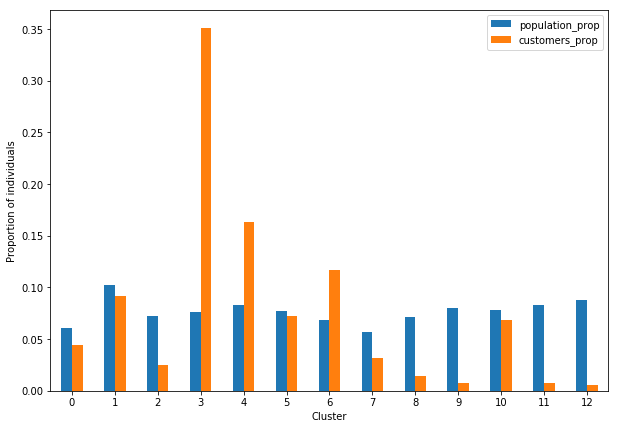

In [2914]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Generate barplot for comparision
cluster_prop.plot(x='cluster', y=['population_prop', 'customers_prop'], kind='bar', figsize=(10,7))
plt.xticks(rotation='horizontal')
plt.xlabel('Cluster')
plt.ylabel('Proportion of individuals')
plt.show()

In [2810]:
cluster_prop

,cluster,population_prop,customers_prop,prop_diff,prop_pct_diff
0,0,0.060707,0.044548,-0.016159,-26.618591
1,1,0.102538,0.091896,-0.010642,-10.378598
2,2,0.072408,0.025402,-0.047006,-64.918179
3,3,0.076230,0.350708,0.274477,360.062512
4,4,0.082884,0.163238,0.080354,96.948184
5,5,0.077202,0.072619,-0.004583,-5.935887
6,6,0.068743,0.116463,0.047720,69.417476
7,7,0.057381,0.031396,-0.025985,-45.284597
8,8,0.071694,0.014175,-0.057519,-80.228492
9,9,0.080486,0.007583,-0.072903,-90.578553


In [2811]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_prop[cluster_prop['prop_pct_diff'] > 50]

,cluster,population_prop,customers_prop,prop_diff,prop_pct_diff
3,3,0.076230,0.350708,0.274477,360.062512
4,4,0.082884,0.163238,0.080354,96.948184
6,6,0.068743,0.116463,0.047720,69.417476


The population and customers cluster proportion barplot indcate that clusters 3, 4, and 6 are over-represented in the customer data compared to the general population.  I calculated the percent difference between customers proportion and the population proportion for each cluster and filtered to those clusters that are greater than 50%.  The results are the same as what I saw on the chart.

In [2819]:
# What kinds of people are part of a cluster that is underrepresented 
# in the customer data compared to the general population?

cluster_prop[cluster_prop['prop_pct_diff'] < -50]

,cluster,population_prop,customers_prop,prop_diff,prop_pct_diff
2,2,0.072408,0.025402,-0.047006,-64.918179
8,8,0.071694,0.014175,-0.057519,-80.228492
9,9,0.080486,0.007583,-0.072903,-90.578553
11,11,0.083419,0.007264,-0.076156,-91.292668
12,12,0.088036,0.005945,-0.082091,-93.246911


The population and customers cluster proportion barplot indcate that clusters 2, 8, 9, 11 and 12 are under-represented in the customer data compared to the general population.    I calculated the percent difference between customers and the population for each cluster.  For the under-represented data I look the negative values and filtered to those clusters that are less than -50%.  The results are the same as what I saw on the chart.

In [2992]:
# Function to return customer data by cluster
def get_customer_data(cluster):
    
    # Get cluster indices
    idx = customer_predict[customer_predict['cluster']==cluster].index
    
    # Create pca dataframe for cluster
    pca = pd.DataFrame(customers_pca).loc[idx]
    
    # Create inverse pca dataframe
    pca_inverse = pca_40.inverse_transform(pca)
    cluster_values = pd.DataFrame(scaler.inverse_transform(pca_inverse), columns=customers_clean.columns, index=idx)
    
    return cluster_values

In [2993]:
# Define features to evaluate over and under represented clusters to try and infer population types

feature_set = ['FINANZ_MINIMALIST','FINANZ_HAUSBAUER','ALTERSKATEGORIE_GROB','HEALTH_TYP','DECADE','SEMIO_FAM',
          'SEMIO_ERL','SEMIO_PFLICHT','SEMIO_TRADV','ONLINE_AFFINITAET','HH_EINKOMMEN_SCORE','MOBI_REGIO','LP_FAMILIE_GROB_1',
               'LP_FAMILIE_GROB_2','LP_FAMILIE_GROB_3','LP_FAMILIE_GROB_4','LP_FAMILIE_GROB_5',
               'LP_STATUS_GROB_1','LP_STATUS_GROB_2','LP_STATUS_GROB_3','LP_STATUS_GROB_4',
               'LP_STATUS_GROB_5','BALLRAUM','REGIOTYP','W_KEIT_KIND_HH']

In [2994]:
rows = []
for i in range(cluster_prop.shape[0]):  
    for feature in feature_set:
        rows.append([i, feature, get_customer_data(cluster=i)[feature].mean()])

# Load into dataframe        
metrics = pd.DataFrame(rows, columns=['cluster','feature','mean_value'])


In [2995]:
metrics

,cluster,feature,mean_value
0,0,FINANZ_MINIMALIST,1.933520
1,0,FINANZ_HAUSBAUER,4.127964
2,0,ALTERSKATEGORIE_GROB,2.927022
3,0,HEALTH_TYP,2.258576
4,0,DECADE,73.899147
...,...,...,...
320,12,LP_STATUS_GROB_4,-0.025124
321,12,LP_STATUS_GROB_5,0.017838
322,12,BALLRAUM,2.978145
323,12,REGIOTYP,3.446639


In [2996]:
# Pivot data such that features appear in columns
metrics = metrics.pivot(index='cluster', columns='feature', values='mean_value').reset_index().rename_axis('',axis=1)
metrics

,cluster,ALTERSKATEGORIE_GROB,BALLRAUM,DECADE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,HEALTH_TYP,HH_EINKOMMEN_SCORE,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,...,LP_STATUS_GROB_4,LP_STATUS_GROB_5,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,SEMIO_ERL,SEMIO_FAM,SEMIO_PFLICHT,SEMIO_TRADV,W_KEIT_KIND_HH
0,0,2.927022,5.466475,73.899147,4.127964,1.933520,2.258576,3.752678,-0.080132,0.117254,...,0.599211,0.228855,2.725564,4.002399,3.488326,2.912981,4.598621,4.077344,4.353975,4.690713
1,1,3.505059,3.654123,62.008574,2.201573,2.565613,2.043120,2.199673,0.514180,0.193326,...,0.005278,0.208323,4.779843,1.894445,3.330935,3.678857,3.199044,5.162598,5.697151,1.841601
2,2,2.997342,3.199646,69.278544,1.893689,3.675080,2.019529,2.044531,0.404535,0.213830,...,0.032440,0.146871,4.905606,2.515497,3.256097,2.145432,5.610094,4.241991,4.648265,2.753121
3,3,3.498813,3.643388,63.624723,4.141037,0.923691,1.948470,4.807572,0.251816,0.110508,...,0.150483,0.621796,2.639517,3.308536,4.718986,3.798189,3.272355,5.163629,5.274529,3.038750
4,4,3.630514,5.476201,63.297355,4.095093,1.134443,2.267258,3.440276,0.299344,0.176024,...,0.684330,0.123410,2.818584,2.636417,3.487817,3.424593,3.504237,5.254385,5.735819,2.820354
5,5,4.007150,3.363243,58.331983,1.370392,3.313240,2.006718,1.637156,0.675812,0.126984,...,-0.080286,0.060070,5.271327,1.310505,3.763254,1.155695,5.931449,6.089929,6.290872,1.817142
6,6,3.699115,3.649176,62.552811,3.716909,1.549402,1.851006,4.555345,0.309524,0.092590,...,0.124441,0.642885,2.661003,3.160594,4.609220,1.501395,6.051444,5.391314,5.306430,3.302279
7,7,3.350652,2.780509,63.934652,2.089251,2.859590,2.529113,1.751284,0.547016,0.145542,...,-0.052054,0.003641,5.868471,1.774097,3.768317,3.676062,2.981335,4.907166,5.338082,2.317683
8,8,2.021720,5.007780,83.094206,4.003238,2.372037,2.315493,3.704186,0.152953,0.110395,...,0.243725,0.342908,3.132446,4.103951,4.167342,5.710692,1.719404,2.701400,3.125051,3.882092
9,9,1.964457,3.084004,82.760278,2.589198,3.629887,2.439245,1.939436,0.462842,0.164483,...,-0.047625,0.132244,5.290101,3.040503,3.562269,5.844463,1.350461,2.636868,3.229624,2.823432


#### Over-represented clusters

In [2997]:
# Filter metrics to over-represented clusters only
over = metrics[metrics['cluster'].isin(cluster_prop[cluster_prop['prop_pct_diff'] > 50].index.tolist())]
over

,cluster,ALTERSKATEGORIE_GROB,BALLRAUM,DECADE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,HEALTH_TYP,HH_EINKOMMEN_SCORE,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,...,LP_STATUS_GROB_4,LP_STATUS_GROB_5,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,SEMIO_ERL,SEMIO_FAM,SEMIO_PFLICHT,SEMIO_TRADV,W_KEIT_KIND_HH
3,3,3.498813,3.643388,63.624723,4.141037,0.923691,1.948470,4.807572,0.251816,0.110508,...,0.150483,0.621796,2.639517,3.308536,4.718986,3.798189,3.272355,5.163629,5.274529,3.038750
4,4,3.630514,5.476201,63.297355,4.095093,1.134443,2.267258,3.440276,0.299344,0.176024,...,0.684330,0.123410,2.818584,2.636417,3.487817,3.424593,3.504237,5.254385,5.735819,2.820354
6,6,3.699115,3.649176,62.552811,3.716909,1.549402,1.851006,4.555345,0.309524,0.092590,...,0.124441,0.642885,2.661003,3.160594,4.609220,1.501395,6.051444,5.391314,5.306430,3.302279


In [2998]:
# Take feature value mean of all over-represented clusters
rows = []
for i in over.columns:
    rows.append([i, over[i].mean()])

# Load into dataframe
over_means = pd.DataFrame(rows, columns=['feature', 'over_mean']).drop(0).reset_index(drop=True)    

In [2999]:
over_means

,feature,over_mean
0,ALTERSKATEGORIE_GROB,3.609481
1,BALLRAUM,4.256255
2,DECADE,63.158296
3,FINANZ_HAUSBAUER,3.984346
4,FINANZ_MINIMALIST,1.202512
5,HEALTH_TYP,2.022245
6,HH_EINKOMMEN_SCORE,4.267731
7,LP_FAMILIE_GROB_1,0.286895
8,LP_FAMILIE_GROB_2,0.126374
9,LP_FAMILIE_GROB_3,-0.015447


#### Under-represented clusters

In [3000]:
# Filter metrics to under-represented clusters only
under = metrics[metrics['cluster'].isin(cluster_prop[cluster_prop['prop_pct_diff'] < -50].index.tolist())]
under

,cluster,ALTERSKATEGORIE_GROB,BALLRAUM,DECADE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,HEALTH_TYP,HH_EINKOMMEN_SCORE,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,...,LP_STATUS_GROB_4,LP_STATUS_GROB_5,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,SEMIO_ERL,SEMIO_FAM,SEMIO_PFLICHT,SEMIO_TRADV,W_KEIT_KIND_HH
2,2,2.997342,3.199646,69.278544,1.893689,3.675080,2.019529,2.044531,0.404535,0.213830,...,0.032440,0.146871,4.905606,2.515497,3.256097,2.145432,5.610094,4.241991,4.648265,2.753121
8,8,2.021720,5.007780,83.094206,4.003238,2.372037,2.315493,3.704186,0.152953,0.110395,...,0.243725,0.342908,3.132446,4.103951,4.167342,5.710692,1.719404,2.701400,3.125051,3.882092
9,9,1.964457,3.084004,82.760278,2.589198,3.629887,2.439245,1.939436,0.462842,0.164483,...,-0.047625,0.132244,5.290101,3.040503,3.562269,5.844463,1.350461,2.636868,3.229624,2.823432
11,11,1.808723,4.917421,88.168020,3.206065,3.722653,2.455243,3.155789,0.322372,0.112505,...,0.080172,0.252016,3.368296,3.799218,3.958750,3.605587,4.544388,2.313975,2.707250,3.908715
12,12,1.727912,2.978145,88.630049,2.243464,4.679030,2.556702,1.587941,0.634527,0.031135,...,-0.025124,0.017838,5.314883,3.086720,3.446639,3.765790,4.166334,2.116705,2.707734,3.318319


In [3001]:
# Take feature value mean of all under-represented clusters
rows = []
for i in under.columns:
    rows.append([i, under[i].mean()])

# Load into dataframe
under_means = pd.DataFrame(rows, columns=['feature', 'under_mean']).drop(0).reset_index(drop=True)

In [3002]:
under_means

,feature,under_mean
0,ALTERSKATEGORIE_GROB,2.104031
1,BALLRAUM,3.837399
2,DECADE,82.386219
3,FINANZ_HAUSBAUER,2.787131
4,FINANZ_MINIMALIST,3.615738
5,HEALTH_TYP,2.357243
6,HH_EINKOMMEN_SCORE,2.486377
7,LP_FAMILIE_GROB_1,0.395446
8,LP_FAMILIE_GROB_2,0.126470
9,LP_FAMILIE_GROB_3,0.046258


In [3003]:
merged_means = over_means.merge(under_means, on='feature')

In [3004]:
merged_means

,feature,over_mean,under_mean
0,ALTERSKATEGORIE_GROB,3.609481,2.104031
1,BALLRAUM,4.256255,3.837399
2,DECADE,63.158296,82.386219
3,FINANZ_HAUSBAUER,3.984346,2.787131
4,FINANZ_MINIMALIST,1.202512,3.615738
5,HEALTH_TYP,2.022245,2.357243
6,HH_EINKOMMEN_SCORE,4.267731,2.486377
7,LP_FAMILIE_GROB_1,0.286895,0.395446
8,LP_FAMILIE_GROB_2,0.126374,0.126470
9,LP_FAMILIE_GROB_3,-0.015447,0.046258


### Discussion 3.3: Compare Customer Data to Demographics Data

I looked at both the over-represented (3, 4, 6) and under-represented (2, 8, 9, 11, 12) clusters from the customers data and compared both types of clusters using features that I have chosen that included financial status, family status, age, income, and amount of movement, which should give a good indication of the type of people, or at least be able to see a difference from feature values between the over and under clusters.  

I took the 20 features and calculated the mean values of each of the individual clusters, and then grouping the over and under clusters in `over_mean` and `under_mean`.  The over-represented clusters were found to probably belong to a segment of the population who are older (`ALTERSKATEGORIE_GROB`), more financially stable (higher `FINANZ_HAUSBAUER` value and lower `FINANZ_MINIMALIST` value.  They also have higher income as seen from the distribution of values in `LP_STATUS_GROB` and the `HH_EINKOMMEN_SCORE` feature.  They also move around less as seen from `MOBI_REGIO`.  In terms of personality they score higher on being family minded, traditional-minded, and dutiful.

From the above findings, I would infer that the company is more focused on above described segment of the population, who are usually more mature and financially stable.  The ones who are  relatively unpopular with the company would typically be younger with less income who have less financial savings.  They also tend to move around from place to place more than the more popular demographic segments of the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.